In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *

In [2]:
import numpy as np
import scipy
import os
import sys
from sklearn.metrics import confusion_matrix
import pandas as pd

In [3]:
from IPython.core.interactiveshell import InteractiveShell
# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

This notebook explains the solution for dataset uploaded in kaggle site for [plant seedling identification](https://www.kaggle.com/c/plant-seedlings-classification/data). Another notebook will be prepared for keras model and we will then compare the fast.ai result with keras.

Each image has a filename that is its unique id. The dataset comprises 12 plant species. The goal of the competition is to create a classifier capable of determining a plant's species from a photo. The list of species is as follows:
- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

API credentials

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials. Place this file in the location ~/.kaggle/kaggle.json (on Windows in the location C:\Users\<Windows-username>\.kaggle\kaggle.json - you can check the exact location, sans drive, with echo %HOMEPATH%). You can define a shell environment variable KAGGLE_CONFIG_DIR to change this location to $KAGGLE_CONFIG_DIR/kaggle.json (on Windows it will be %KAGGLE_CONFIG_DIR%\kaggle.json).

For your security, ensure that other users of your computer do not have read access to your credentials. On Unix-based systems you can do this with the following command:

chmod 600 ~/.kaggle/kaggle.json

You can also choose to export your Kaggle username and token to the environment:

export KAGGLE_USERNAME=datadinosaur

export KAGGLE_KEY=xxxxxxxxxxxxxx

In addition, you can export any other configuration value that normally would be in the $HOME/.kaggle/kaggle.json in the format 'KAGGLE_' (note uppercase).
For example, if the file had the variable "proxy" you would export KAGGLE_PROXY and it would be discovered by the client.
    
 

In [4]:
# ! kaggle competitions download -c histopathologic-cancer-detection -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

In [5]:
# Command-Line Interface

# The zipfile module provides a simple command-line interface to interact with ZIP archives.

# If you want to create a new ZIP archive, specify its name after the -c option and then list the filename(s) that should be included:

# $ python -m zipfile -c monty.zip spam.txt eggs.txt

# Passing a directory is also acceptable:

# $ python -m zipfile -c monty.zip life-of-brian_1979/

# If you want to extract a ZIP archive into the specified directory, use the -e option:

# $ python -m zipfile -e monty.zip target-dir/

# For a list of the files in a ZIP archive, use the -l option:

# $ python -m zipfile -l monty.zip



## Multiclassification

In [6]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True)
    Download `url` if it doesn't exist to `fname` and un-tgz to folder `dest`



Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to one tag.

In [7]:
# URL.CANCER_DATA = '/home/nbuser/courses/fast-ai/course-v3/nbs/data/oxford-iiit-pet'
# path = untar_data(URL.CANCER_DATA); path
path = '/home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling'

In [8]:
np.random.seed(42)

src_plant = (ImageItemList.from_folder(path, folder='train', suffix='.png')
       .random_split_by_pct(0.2)
       .label_from_folder())

In [35]:
tfms = get_transforms(flip_vert=True, max_lighting=0.3, max_zoom=1.05, max_warp=0.)

In [36]:
data = (src_plant.transform(tfms, size=64)
        .databunch().normalize(imagenet_stats))

In [73]:
data.c

13

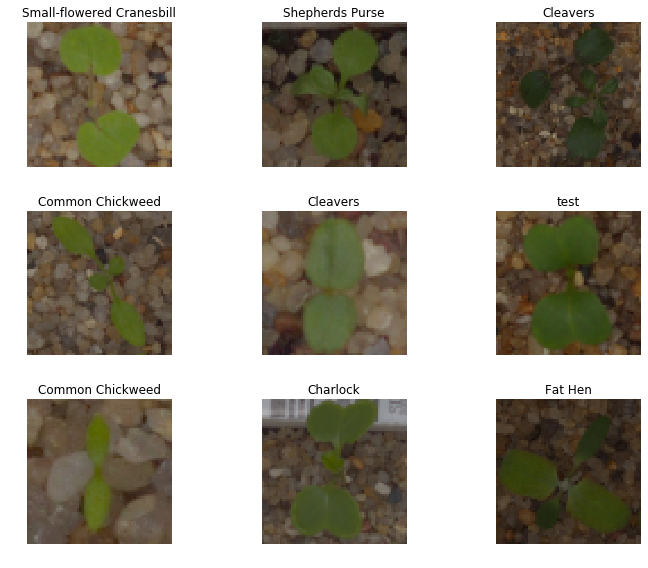

In [37]:
data.show_batch(rows=3, figsize=(10,8))

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. we are building a model which will take images as input and will output the predicted probability for each of the categories.

We will train for 4 epochs (4 cycles through all our data).

In [38]:
plant_celllearn = create_cnn(data, models.resnet50, metrics=error_rate)

In [101]:
?create_cnn

In [39]:
plant_celllearn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate
1,2.384119,1.847767,0.603791
2,1.909947,1.568109,0.519856
3,1.603790,1.301791,0.450361
4,1.393703,1.158924,0.405235
5,1.270808,1.080876,0.390794
6,1.178142,1.082215,0.389892


In [40]:
plant_celllearn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate
1,1.180806,1.037929,0.368231
2,1.194647,1.008390,0.361913
3,1.110218,0.931102,0.348375
4,1.032843,0.859581,0.316787
5,0.933680,0.824630,0.295126
6,0.902819,0.804783,0.293321


In [41]:
plant_celllearn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate
1,0.880676,0.819398,0.309567
2,0.911066,0.830481,0.295126
3,0.883561,0.775368,0.278881
4,0.845707,0.746418,0.271661
5,0.792792,0.708517,0.255415
6,0.749795,0.703085,0.253610


In [42]:
plant_celllearn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


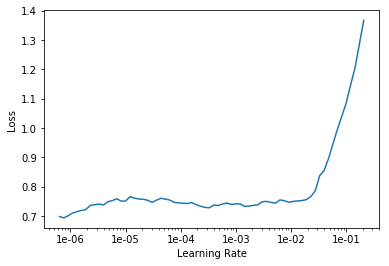

In [43]:
plant_celllearn.recorder.plot()

In [45]:
plant_celllearn.fit_one_cycle(4, max_lr=slice(1e-7,1e-6))

epoch,train_loss,valid_loss,error_rate
1,0.734635,0.712443,0.260830
2,0.747686,0.702112,0.247292
3,0.746826,0.709264,0.259025
4,0.749136,0.702133,0.255415


In [46]:
plant_celllearn.freeze_to(-5)  ## here we are unfreezing last 3 three layer

In [47]:
plant_celllearn.fit_one_cycle(4, max_lr=slice(1e-6,1e-7))

epoch,train_loss,valid_loss,error_rate
1,0.781862,0.695278,0.254513
2,0.761945,0.705653,0.260830
3,0.757801,0.712237,0.252708
4,0.744761,0.701221,0.250903


In [48]:
plant_celllearn.save('stage-1-plant_celllearn-fast_ai')

In [49]:
plant_celllearn.unfreeze()

In [50]:
plant_celllearn.fit_one_cycle(4, max_lr=slice(1e-6,1e-7))

epoch,train_loss,valid_loss,error_rate
1,0.730183,0.698875,0.246390
2,0.729234,0.692049,0.242780
3,0.736719,0.710264,0.252708
4,0.734422,0.693472,0.246390


## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

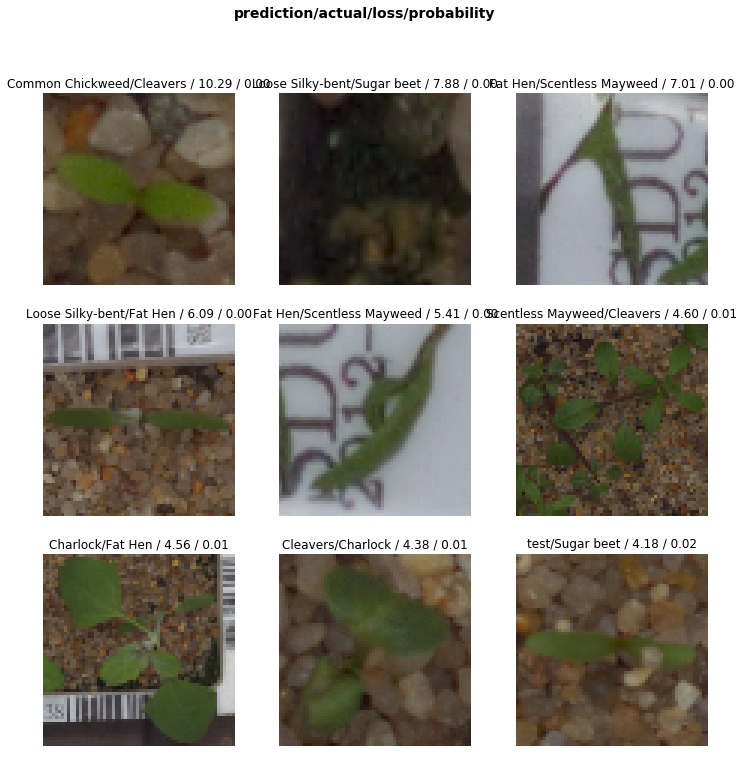

In [51]:
plant_celllearn_interp = ClassificationInterpretation.from_learner(plant_celllearn)
plant_celllearn_interp.plot_top_losses(9, figsize=(12,12))

In [52]:
tfms_2 = get_transforms(flip_vert=True, max_lighting=0.3, max_warp=0.)

In [53]:
data_2 = (src_plant.transform(tfms_2, size=64)
        .databunch().normalize(imagenet_stats))

In [54]:
plant_celllearn = create_cnn(data_2, models.resnet50, metrics=error_rate)

In [55]:
plant_celllearn.load('stage-1-plant_celllearn-fast_ai')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (4436 items)
[Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (4436 items)
[Image (3, 920, 920), Image (3, 744, 744), Image (3, 1289, 1289), Image (3, 511, 511), Image (3, 1546, 1546)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Valid: LabelList
y: CategoryList (1108 items)
[Category Shepherds Purse, Category Common wheat, Category test, Category Sugar beet, Category Common Chickweed]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (1108 items)
[Image (3, 399, 399), Image (3, 113, 113), Image (3, 280, 280), Image (3, 611, 611), Image (3, 140, 140)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), st

In [56]:
plant_celllearn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate
1,0.744516,0.694761,0.247292
2,0.772307,0.704547,0.279783
3,0.766973,0.673727,0.244585
4,0.738234,0.685672,0.255415
5,0.702281,0.646817,0.237365
6,0.666560,0.634204,0.234657


In [57]:
plant_celllearn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


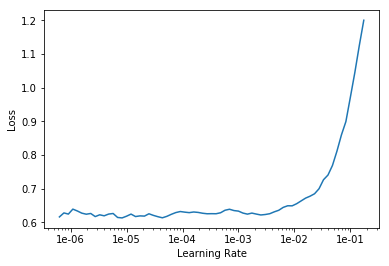

In [58]:
plant_celllearn.recorder.plot()

In [59]:
#plant_celllearn.fit_one_cycle(6,max_lr=(1e-4, 1e-5, 1e-6), wd=(1e-4,1e-5,1e-6))


In [60]:
plant_celllearn.save('stage-2-plant_celllearn-fast_ai')

In [61]:
plant_celllearn.fit_one_cycle(5, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate
1,0.652681,0.643028,0.242780
2,0.645152,0.643610,0.250000
3,0.646637,0.635276,0.232852
4,0.643307,0.631785,0.230144
5,0.645423,0.635837,0.243682


In [62]:
plant_celllearn.save('stage-3-plant_celllearn-fast_ai')

In [63]:
# only randomly initialized head now trainable
plant_celllearn.freeze_to(12)

In [64]:
# all layers now trainable
#cancer_celllearn_50.unfreeze(-12)
# optionally, separate LR and WD for each group
plant_celllearn.fit_one_cycle(4, max_lr=(1e-8, 1e-7, 1e-6), wd=(1e-8, 1e-7, 1e-6))

epoch,train_loss,valid_loss,error_rate
1,0.660842,0.643836,0.245487
2,0.659452,0.633831,0.231047
3,0.664242,0.634770,0.237365
4,0.672400,0.635134,0.233755


In [65]:
plant_celllearn.save('stage-4-plant_celllearn-fast_ai')

## Prediction on Test Data

Lets test our model on two sample data and print the prediction value.

Now we will automate to read all the images from test directory and predict their class to indicate tumor cell presence. Output file name should have image file identifier and prediction class.

In [95]:
## defining the list to hold file id and their predicton.
imagepreds = []
fileids = []

In [96]:
#print int(os.popen("ls | wc -l").read())
print(len(os.listdir('/home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling/test/'))) # dir is your directory path

794


In [97]:
img = open_image('/home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling/test/14bb43eee.png')
predictionarray = plant_celllearn.predict(img)
#predictionarray
KK= predictionarray[0]
#KK[:10]
str(KK)

'Common wheat'

In [98]:
count =1
for file in os.listdir('/home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling/test/'):
    filename = os.path.join('/home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling/test/', file)
    imgtest = open_image(filename)
    predictionarray = plant_celllearn.predict(imgtest)
    file
    str(predictionarray[0])
#     count = count +1
#     count
    #file_mod = file.strip('.tif')
    #file_mod = file[:-4]

    fileids.append(file)
    imagepreds.append(str(predictionarray[0]))


'76dbd1054.png'

'test'

'9d3cb4745.png'

'test'

'e9cd91682.png'

'Common Chickweed'

'14bb43eee.png'

'Common wheat'

'6bce55e05.png'

'Charlock'

'808cf55c6.png'

'test'

'406ecb5c5.png'

'Charlock'

'b7a7f6390.png'

'test'

'caa2fbd79.png'

'test'

'172f9b10b.png'

'test'

'a8de7c1b7.png'

'test'

'7c85b0265.png'

'test'

'a9d2eab61.png'

'test'

'37714071b.png'

'test'

'ad12382d4.png'

'test'

'4049a6ea6.png'

'test'

'e15472085.png'

'test'

'606647f64.png'

'test'

'9baf94467.png'

'Sugar beet'

'39b740f7e.png'

'test'

'80e299ae9.png'

'test'

'25a4c427e.png'

'test'

'55251925f.png'

'test'

'592cc5b89.png'

'test'

'17529c555.png'

'test'

'a800caead.png'

'Sugar beet'

'c74c5b7fc.png'

'test'

'6b9d6f8c9.png'

'test'

'a8da9c08d.png'

'test'

'e721c6ac8.png'

'test'

'1c52ea820.png'

'test'

'33748968f.png'

'Cleavers'

'5ee9d0a5b.png'

'test'

'24dbc3b21.png'

'test'

'8f523520c.png'

'Shepherds Purse'

'9b4800b42.png'

'test'

'b573b7a56.png'

'test'

'4f83143e1.png'

'test'

'aaf4da98f.png'

'test'

'bb1d1bfd3.png'

'Charlock'

'65d08b894.png'

'test'

'd102e1a15.png'

'Cleavers'

'a19c3faca.png'

'test'

'c7eb96871.png'

'Common wheat'

'bebcaab66.png'

'test'

'05341a8a6.png'

'test'

'6da892be6.png'

'Small-flowered Cranesbill'

'e96e57a90.png'

'test'

'08d591441.png'

'test'

'5eb9c26a6.png'

'test'

'0e8492cb1.png'

'test'

'bf3924a57.png'

'test'

'b5c7fd009.png'

'Black-grass'

'c5078bac5.png'

'Black-grass'

'785a73ab8.png'

'test'

'29bab7cad.png'

'test'

'e783f5a4f.png'

'test'

'dce2f6612.png'

'test'

'00ef713a8.png'

'test'

'f6d250856.png'

'test'

'24c94a6ca.png'

'test'

'8a30b2de3.png'

'test'

'dcd7ff249.png'

'test'

'0c27cf05f.png'

'test'

'593896f83.png'

'test'

'd2f422ccb.png'

'Common Chickweed'

'3f64c2c1b.png'

'test'

'7615e52d3.png'

'Cleavers'

'486e59179.png'

'Common Chickweed'

'9aa5587fe.png'

'Loose Silky-bent'

'219fd68d5.png'

'Scentless Mayweed'

'a35fd6fbb.png'

'Common Chickweed'

'4b032563b.png'

'test'

'126a71ce0.png'

'test'

'187668bde.png'

'test'

'71f5323c5.png'

'Loose Silky-bent'

'8e6ec1ca6.png'

'Small-flowered Cranesbill'

'46c14fde2.png'

'Loose Silky-bent'

'0c5f6c493.png'

'test'

'0086a6340.png'

'Common Chickweed'

'429211ee6.png'

'test'

'506347cfe.png'

'test'

'ffc6f8527.png'

'test'

'86c309150.png'

'test'

'089ad62a7.png'

'Common Chickweed'

'36839d5e9.png'

'test'

'756dd5070.png'

'test'

'fd87b36ae.png'

'test'

'cf46d09c5.png'

'Common Chickweed'

'2693e5c65.png'

'test'

'c0461776c.png'

'Common Chickweed'

'8585f9718.png'

'Loose Silky-bent'

'65e97117e.png'

'test'

'8d6991365.png'

'test'

'd84d37a61.png'

'Common Chickweed'

'6ba4ef411.png'

'test'

'589e643b8.png'

'Shepherds Purse'

'686dc7ec8.png'

'test'

'8c9953903.png'

'Fat Hen'

'19fdf19fb.png'

'test'

'5ca0205f9.png'

'Charlock'

'cb76a7766.png'

'test'

'0ebf8f2f4.png'

'test'

'7d22abf91.png'

'test'

'a935ca110.png'

'test'

'618de3d7a.png'

'test'

'4e69d100a.png'

'test'

'a1da8be3c.png'

'test'

'6edb96d45.png'

'Cleavers'

'df11d56a7.png'

'test'

'c5e88cd42.png'

'Common Chickweed'

'668c1007c.png'

'Charlock'

'd41d87796.png'

'test'

'cae684f8f.png'

'test'

'699d3c707.png'

'test'

'085974290.png'

'test'

'490c4f9c8.png'

'Common wheat'

'8455169fe.png'

'test'

'fda39e16f.png'

'Loose Silky-bent'

'6df8e31ea.png'

'Charlock'

'd488a4fe1.png'

'test'

'856f2910a.png'

'Small-flowered Cranesbill'

'3f92d8039.png'

'Loose Silky-bent'

'07e62f903.png'

'test'

'd93c7ab6d.png'

'test'

'a1e0a6c02.png'

'test'

'b1cd2a91e.png'

'Cleavers'

'f4caf74f9.png'

'Charlock'

'043449b0b.png'

'test'

'f445fe6fb.png'

'test'

'f351ce097.png'

'test'

'e73e308be.png'

'test'

'e1a0e3202.png'

'Loose Silky-bent'

'7cabd68cc.png'

'Loose Silky-bent'

'f4ad9d950.png'

'Sugar beet'

'3fbd0fc6a.png'

'test'

'da5255450.png'

'Common Chickweed'

'4a337a4a9.png'

'Fat Hen'

'827279bad.png'

'test'

'1b490196c.png'

'test'

'632156793.png'

'Scentless Mayweed'

'd14aa43f3.png'

'Small-flowered Cranesbill'

'0c51bf229.png'

'test'

'ab35453cb.png'

'Cleavers'

'0f6cbe5e8.png'

'test'

'9a3f20121.png'

'Loose Silky-bent'

'48d97c645.png'

'Small-flowered Cranesbill'

'2d5058a59.png'

'Common Chickweed'

'dc55449b2.png'

'test'

'1459e96a0.png'

'Cleavers'

'ae90f2827.png'

'test'

'966ae5ad9.png'

'Loose Silky-bent'

'9b9911f20.png'

'test'

'c4ed8ed38.png'

'Charlock'

'03e322a29.png'

'test'

'edfdb4aeb.png'

'test'

'4ea7493d5.png'

'test'

'19b51843a.png'

'Common Chickweed'

'721b2c47a.png'

'test'

'7b21ba6ba.png'

'test'

'dfb1d9012.png'

'test'

'af45e222a.png'

'test'

'958bb9e96.png'

'test'

'e98e5d1d5.png'

'test'

'063363305.png'

'Small-flowered Cranesbill'

'c60e91e07.png'

'Loose Silky-bent'

'99569b224.png'

'test'

'fe29629fb.png'

'test'

'38c054379.png'

'Small-flowered Cranesbill'

'9d79a1f0c.png'

'Small-flowered Cranesbill'

'adb7a032c.png'

'test'

'da231c97f.png'

'test'

'cf90fc52d.png'

'test'

'8cf2e3e6c.png'

'test'

'b026bf8ca.png'

'Loose Silky-bent'

'9fab816f2.png'

'Fat Hen'

'ef74dbcad.png'

'test'

'ce15eee52.png'

'Charlock'

'36d62bf36.png'

'test'

'33317fc2a.png'

'Fat Hen'

'9326bda1b.png'

'Common Chickweed'

'76555b064.png'

'test'

'8c98a6e9b.png'

'Loose Silky-bent'

'b4c3df835.png'

'Maize'

'c2de6020a.png'

'Small-flowered Cranesbill'

'9c32a797e.png'

'test'

'61b044411.png'

'test'

'ec08a5d56.png'

'Small-flowered Cranesbill'

'31fcdc161.png'

'test'

'a254d71f6.png'

'test'

'752101fdf.png'

'Small-flowered Cranesbill'

'b7ad92859.png'

'Shepherds Purse'

'85431c075.png'

'test'

'60fea2ef6.png'

'test'

'2d9c798f9.png'

'Small-flowered Cranesbill'

'd2f0f326e.png'

'Charlock'

'42e7ed442.png'

'Shepherds Purse'

'0ee4ad224.png'

'test'

'1fefb54b7.png'

'test'

'241e6935a.png'

'test'

'592473c83.png'

'Loose Silky-bent'

'55fed435f.png'

'test'

'22e79540f.png'

'Cleavers'

'1be0713da.png'

'Cleavers'

'74fd477eb.png'

'Common Chickweed'

'a85b48a95.png'

'test'

'b0acaff4a.png'

'Fat Hen'

'a74d475c2.png'

'Common Chickweed'

'446f7da01.png'

'test'

'fea1d13d6.png'

'test'

'279df95f2.png'

'Sugar beet'

'3f826b318.png'

'test'

'd09d24c58.png'

'Loose Silky-bent'

'b3e08b037.png'

'Fat Hen'

'7fdb7202d.png'

'test'

'dd9f36df7.png'

'Small-flowered Cranesbill'

'e84464f5a.png'

'Cleavers'

'3d65168c2.png'

'test'

'ace8761dd.png'

'Common Chickweed'

'770a265f5.png'

'Small-flowered Cranesbill'

'003d61042.png'

'Fat Hen'

'b4f7c9214.png'

'test'

'20817c846.png'

'test'

'b7192c70f.png'

'test'

'b6a3f7876.png'

'Loose Silky-bent'

'00c47e980.png'

'Sugar beet'

'54b3afd58.png'

'Cleavers'

'8a4d3a1b1.png'

'Loose Silky-bent'

'59c6a9f95.png'

'Fat Hen'

'664194d19.png'

'Small-flowered Cranesbill'

'523e5505c.png'

'test'

'cd6adba97.png'

'Small-flowered Cranesbill'

'52dc7a4d6.png'

'test'

'8e29abce1.png'

'test'

'1926e82fd.png'

'Loose Silky-bent'

'8d6acbe9b.png'

'test'

'5bdcfa329.png'

'Loose Silky-bent'

'e88bf0db9.png'

'test'

'23e480e64.png'

'test'

'59e1cea8d.png'

'Cleavers'

'54c8bb900.png'

'Charlock'

'55a852f40.png'

'test'

'9cce7328c.png'

'test'

'5bd71f445.png'

'test'

'4e1190d78.png'

'test'

'590f5aea6.png'

'Charlock'

'11d3f68ff.png'

'test'

'539961189.png'

'Common Chickweed'

'0021e90e4.png'

'Small-flowered Cranesbill'

'8a8d6c712.png'

'Cleavers'

'897e5a8de.png'

'Cleavers'

'5a6bf96f6.png'

'test'

'03a2ee656.png'

'test'

'5c3cd7ea2.png'

'test'

'41e07778c.png'

'Cleavers'

'1758a1baf.png'

'test'

'835dc5447.png'

'Small-flowered Cranesbill'

'223e4af09.png'

'Cleavers'

'1694a70e4.png'

'test'

'19e58cc5e.png'

'Common Chickweed'

'78c5fba1d.png'

'test'

'90b595f12.png'

'test'

'63c07d340.png'

'test'

'5e6a237f2.png'

'test'

'cec5bf198.png'

'test'

'1364b297a.png'

'Cleavers'

'fadc6adbc.png'

'test'

'a83820a2c.png'

'test'

'f1f7c833f.png'

'Shepherds Purse'

'3efa1f66c.png'

'test'

'f4021df6c.png'

'test'

'0caeda5df.png'

'test'

'b341d0aab.png'

'test'

'e0ec5b6a1.png'

'test'

'4823c3ffa.png'

'test'

'0ad9e7dfb.png'

'Maize'

'a8388a37f.png'

'test'

'a0b393945.png'

'Small-flowered Cranesbill'

'e901b0f28.png'

'Fat Hen'

'33448fe39.png'

'test'

'74068643d.png'

'test'

'c35efa095.png'

'test'

'c10db7ae2.png'

'test'

'dc4cd56a3.png'

'test'

'ef7a5651d.png'

'test'

'377283a21.png'

'test'

'afa446484.png'

'Small-flowered Cranesbill'

'8e3ed0a25.png'

'test'

'8cf909eb3.png'

'Charlock'

'3526b05cc.png'

'test'

'd17f48d3b.png'

'test'

'f4e7733d4.png'

'test'

'c10ccbd82.png'

'test'

'604dd663f.png'

'Shepherds Purse'

'653193c1a.png'

'test'

'b30ab4659.png'

'test'

'270b939cf.png'

'Common Chickweed'

'1541bdb2e.png'

'test'

'a74bf916d.png'

'test'

'e19673dc9.png'

'test'

'a8b431a3e.png'

'Sugar beet'

'b39c71707.png'

'test'

'2a667e099.png'

'test'

'dabe3e5be.png'

'Small-flowered Cranesbill'

'1191ba346.png'

'Cleavers'

'5a38ac566.png'

'test'

'19618ad6a.png'

'Fat Hen'

'41f1c3cdb.png'

'Fat Hen'

'8cfd98117.png'

'test'

'a544fc46d.png'

'test'

'8ca6140ca.png'

'test'

'e5881dd33.png'

'test'

'79dafec17.png'

'Loose Silky-bent'

'8ab8a958b.png'

'test'

'02cfeb38d.png'

'test'

'0885e7690.png'

'test'

'29ce426a1.png'

'test'

'73260a4ee.png'

'Fat Hen'

'df521c0c0.png'

'test'

'b98327bf4.png'

'test'

'cadab6616.png'

'Shepherds Purse'

'f9f35cbd4.png'

'test'

'24a058589.png'

'Charlock'

'cf3a8b2fd.png'

'Loose Silky-bent'

'f3fcfff1b.png'

'Cleavers'

'b130a0632.png'

'Cleavers'

'2f246d688.png'

'test'

'f593c9cf0.png'

'test'

'71b232519.png'

'Black-grass'

'e4d5ec761.png'

'Loose Silky-bent'

'4c5ab9b68.png'

'Cleavers'

'6d6eb3830.png'

'test'

'67ce3eaa6.png'

'Small-flowered Cranesbill'

'e19ad6ac9.png'

'Charlock'

'f8318faf1.png'

'test'

'ef3e232ad.png'

'test'

'ac3193f78.png'

'test'

'd689256be.png'

'test'

'1dc7c45df.png'

'test'

'c50335991.png'

'Fat Hen'

'fc6f686fb.png'

'test'

'a2c89c367.png'

'Charlock'

'eaf0815e2.png'

'Small-flowered Cranesbill'

'35a90f8d0.png'

'test'

'148bbda66.png'

'Charlock'

'48ef6a2ff.png'

'test'

'974959ec1.png'

'test'

'97b2f0a10.png'

'Small-flowered Cranesbill'

'8104422bb.png'

'test'

'e1809cef2.png'

'Common Chickweed'

'3a909ead8.png'

'test'

'4bbfd1e05.png'

'Cleavers'

'26852751a.png'

'Charlock'

'cbba27d89.png'

'test'

'aecfaed64.png'

'test'

'a0f37c726.png'

'test'

'550a8b7e6.png'

'test'

'c75a82234.png'

'test'

'0751c0bbc.png'

'test'

'3da774107.png'

'test'

'61dd2cdc5.png'

'test'

'8a32d0bfa.png'

'test'

'67e185673.png'

'Small-flowered Cranesbill'

'acdb75e00.png'

'Loose Silky-bent'

'f23faf9c1.png'

'test'

'1623fb9e1.png'

'Fat Hen'

'6049234e6.png'

'Fat Hen'

'8170d33c1.png'

'Maize'

'205df1df3.png'

'test'

'20ea96bcc.png'

'Fat Hen'

'f66ae4070.png'

'test'

'59b2c6f2b.png'

'Common Chickweed'

'd0152bd7c.png'

'test'

'ef65533d5.png'

'Loose Silky-bent'

'165681fd9.png'

'test'

'466bb6d3b.png'

'test'

'3bbef3ecb.png'

'test'

'ef02b4ee7.png'

'test'

'98062cd87.png'

'Shepherds Purse'

'5f04aed97.png'

'Small-flowered Cranesbill'

'7d3045fc3.png'

'Sugar beet'

'976e4e079.png'

'test'

'7696badea.png'

'test'

'e5297b675.png'

'test'

'969a851be.png'

'test'

'728eabae1.png'

'Charlock'

'862b8e7a0.png'

'test'

'60ee66ddd.png'

'Cleavers'

'65489944f.png'

'Shepherds Purse'

'47b7d8e17.png'

'Small-flowered Cranesbill'

'5883b423d.png'

'test'

'03566743d.png'

'test'

'5b3beec58.png'

'Loose Silky-bent'

'24d36c52c.png'

'test'

'a2d25b4f3.png'

'test'

'2dd5cfba9.png'

'test'

'391dcd7fd.png'

'test'

'0ae6668fa.png'

'Loose Silky-bent'

'dd5ec63d9.png'

'test'

'82b5f4d33.png'

'test'

'cc74feadc.png'

'Loose Silky-bent'

'3b73c3b61.png'

'test'

'060450d79.png'

'test'

'f85ed9b6d.png'

'test'

'0c45ace27.png'

'test'

'bfab3e3d0.png'

'test'

'8e2e5604e.png'

'test'

'abf8b0772.png'

'Scentless Mayweed'

'4b155fb07.png'

'Maize'

'5af1d74ee.png'

'test'

'99036c51d.png'

'Loose Silky-bent'

'a890ac088.png'

'Charlock'

'659412b1a.png'

'Loose Silky-bent'

'22fbf13d6.png'

'test'

'3e9f41817.png'

'Loose Silky-bent'

'd89db156f.png'

'test'

'4bbf1f6ea.png'

'test'

'7506c0c02.png'

'test'

'30ad31220.png'

'Charlock'

'be341dbdc.png'

'Loose Silky-bent'

'6db684fff.png'

'test'

'35cf9fa01.png'

'Shepherds Purse'

'55920f07f.png'

'test'

'b6f3d8b5d.png'

'Scentless Mayweed'

'177d7e2a4.png'

'test'

'04814f36d.png'

'test'

'abc331628.png'

'test'

'c06e7c748.png'

'test'

'f0ffa00bd.png'

'test'

'c0f5d9ac8.png'

'Small-flowered Cranesbill'

'ce42adffb.png'

'Loose Silky-bent'

'3ebbe9ca4.png'

'Charlock'

'9c8b08a24.png'

'test'

'ab0f67743.png'

'test'

'647689543.png'

'Loose Silky-bent'

'cb496f36e.png'

'Loose Silky-bent'

'ff65bc002.png'

'Charlock'

'8b9144917.png'

'test'

'675ec1b0b.png'

'Small-flowered Cranesbill'

'87608f7aa.png'

'test'

'7b52585da.png'

'Scentless Mayweed'

'5296835a0.png'

'Small-flowered Cranesbill'

'98d819587.png'

'Shepherds Purse'

'780defa2e.png'

'test'

'837ac0270.png'

'test'

'65e262a6d.png'

'Charlock'

'808578ed5.png'

'test'

'd01873fdd.png'

'Loose Silky-bent'

'410e6f702.png'

'Small-flowered Cranesbill'

'35ebe165c.png'

'Loose Silky-bent'

'26e7ae885.png'

'test'

'c7b07431e.png'

'test'

'0bf7bfb05.png'

'Loose Silky-bent'

'bb64660b7.png'

'test'

'b62dca166.png'

'Fat Hen'

'a85fc8c9a.png'

'Small-flowered Cranesbill'

'953496deb.png'

'test'

'31f3dd81f.png'

'test'

'ef9676433.png'

'Charlock'

'd6c8c3c48.png'

'test'

'4e9d3765f.png'

'Charlock'

'a55d26a4c.png'

'test'

'c0d9e170b.png'

'test'

'17a78fb44.png'

'Common wheat'

'32a8c8a1d.png'

'Loose Silky-bent'

'75cb95e91.png'

'Charlock'

'3abb502fb.png'

'test'

'79fba50db.png'

'test'

'be2499cf4.png'

'test'

'ac75d3326.png'

'test'

'995c7ab1e.png'

'Fat Hen'

'5b63dcc21.png'

'test'

'6edc76e7c.png'

'Fat Hen'

'fda0b5c38.png'

'test'

'6a41bf95b.png'

'test'

'e5368474f.png'

'test'

'87f627bf9.png'

'test'

'79d93bc96.png'

'test'

'16fd2e01a.png'

'Small-flowered Cranesbill'

'17d5e5ac4.png'

'test'

'fd925f542.png'

'test'

'12625488b.png'

'Fat Hen'

'beebe5f4e.png'

'Scentless Mayweed'

'9c777333d.png'

'test'

'6908fb540.png'

'test'

'5779fe8b4.png'

'test'

'69d1669f8.png'

'Charlock'

'd7017f701.png'

'Fat Hen'

'59f62ad1d.png'

'test'

'e14afa235.png'

'test'

'1bf9b94a6.png'

'test'

'bd72d4d8a.png'

'test'

'cc3d2a59a.png'

'test'

'c88ebfb47.png'

'Small-flowered Cranesbill'

'0911d3dee.png'

'test'

'0c4199daa.png'

'test'

'8ece6efec.png'

'test'

'4c8005bbc.png'

'test'

'f9ea23fb5.png'

'Fat Hen'

'de0b79659.png'

'Fat Hen'

'c63da993b.png'

'Sugar beet'

'1f3f44563.png'

'test'

'c7051c902.png'

'test'

'8303b27ed.png'

'Loose Silky-bent'

'800a8c17e.png'

'Fat Hen'

'25fa8d109.png'

'test'

'1821eb11a.png'

'test'

'3185294c8.png'

'test'

'288564c76.png'

'Sugar beet'

'3eebd36c6.png'

'Charlock'

'd5f7dd60a.png'

'test'

'c0bc3997b.png'

'test'

'dabea05f4.png'

'test'

'bdde957ec.png'

'test'

'fd253a74e.png'

'Cleavers'

'615d2b0a9.png'

'test'

'007b3da8b.png'

'test'

'0437393b1.png'

'Fat Hen'

'44e8b8833.png'

'Small-flowered Cranesbill'

'a3b375b34.png'

'Loose Silky-bent'

'2ea664465.png'

'test'

'da9ef7858.png'

'test'

'aa7d098d1.png'

'test'

'8dbb8e1b9.png'

'test'

'6b721f68e.png'

'test'

'e6f1211a2.png'

'test'

'03ef36742.png'

'test'

'71334c634.png'

'test'

'239bdf640.png'

'Charlock'

'cfb18d262.png'

'test'

'3eda9cbb6.png'

'test'

'338c7e907.png'

'Charlock'

'6680836dd.png'

'test'

'd350a25fa.png'

'Common Chickweed'

'8b27bfd2b.png'

'Small-flowered Cranesbill'

'b944a49ca.png'

'test'

'aee6fa3df.png'

'test'

'8faadb6a8.png'

'test'

'2b55a2da2.png'

'test'

'a7bd7cadb.png'

'Fat Hen'

'66ab0e8d0.png'

'Charlock'

'521b27a17.png'

'test'

'bea23d9f8.png'

'Scentless Mayweed'

'71e73a8a0.png'

'Sugar beet'

'2e86f1085.png'

'Fat Hen'

'e52493d0b.png'

'test'

'56112b92c.png'

'Small-flowered Cranesbill'

'534e74d83.png'

'test'

'502dff972.png'

'Small-flowered Cranesbill'

'6c874918c.png'

'Loose Silky-bent'

'e471f1d3a.png'

'Charlock'

'96ecad7a1.png'

'test'

'8916793ce.png'

'Small-flowered Cranesbill'

'4287d810c.png'

'Common Chickweed'

'32b42c120.png'

'Small-flowered Cranesbill'

'3827436f3.png'

'Common Chickweed'

'fe9e87b78.png'

'test'

'd668409ff.png'

'test'

'7f46a71db.png'

'test'

'df7cb5f87.png'

'test'

'cd5f0db1c.png'

'test'

'd563be369.png'

'Fat Hen'

'0d117d910.png'

'Common Chickweed'

'78b1bf91a.png'

'Sugar beet'

'7f9e9565d.png'

'Scentless Mayweed'

'7f31c7f42.png'

'test'

'c64370a72.png'

'test'

'c6b76307d.png'

'test'

'b03397525.png'

'Loose Silky-bent'

'060f1dc84.png'

'test'

'39858776a.png'

'Cleavers'

'16467a950.png'

'Loose Silky-bent'

'4e18ab737.png'

'Cleavers'

'b29339405.png'

'test'

'bf66b9cd2.png'

'test'

'a3d0031fd.png'

'test'

'9516e56c4.png'

'Loose Silky-bent'

'fba8fc78a.png'

'test'

'cfd8165e9.png'

'Charlock'

'099b961ec.png'

'test'

'56a01b835.png'

'test'

'6a47821f9.png'

'Loose Silky-bent'

'20e562fd5.png'

'test'

'bb1c84bbc.png'

'test'

'50de8a115.png'

'test'

'7beb2766f.png'

'test'

'25cf6eb73.png'

'test'

'8874bba69.png'

'test'

'2df78338c.png'

'test'

'a38b8a581.png'

'Small-flowered Cranesbill'

'0d31e6602.png'

'Small-flowered Cranesbill'

'da713c465.png'

'test'

'64fe8beb9.png'

'test'

'a276c65f7.png'

'test'

'd9c50616e.png'

'test'

'a2b703e21.png'

'test'

'8b043093d.png'

'Small-flowered Cranesbill'

'c1ecff98b.png'

'Loose Silky-bent'

'3281183f9.png'

'test'

'e5e3dccff.png'

'test'

'892e9d6c6.png'

'test'

'fea355851.png'

'test'

'248436078.png'

'Cleavers'

'fdea6b119.png'

'Black-grass'

'9df3275da.png'

'Small-flowered Cranesbill'

'8301b0547.png'

'Cleavers'

'3d38a87bc.png'

'Loose Silky-bent'

'f9b6bfb00.png'

'Cleavers'

'a169b71e7.png'

'test'

'7691014a1.png'

'Charlock'

'59358cd44.png'

'Small-flowered Cranesbill'

'f4234cf4f.png'

'Fat Hen'

'f2dc546ca.png'

'Cleavers'

'2d992d1fb.png'

'Loose Silky-bent'

'a060c1cf8.png'

'test'

'e7077322d.png'

'test'

'6dd095129.png'

'Common Chickweed'

'116b136de.png'

'test'

'b47691c08.png'

'test'

'7a38416be.png'

'Charlock'

'824f5d4e5.png'

'Sugar beet'

'8bc0261c9.png'

'test'

'9643fc5f4.png'

'Charlock'

'f48916a8c.png'

'test'

'1376f3b63.png'

'test'

'599691cd9.png'

'Small-flowered Cranesbill'

'c069fc3fa.png'

'Fat Hen'

'37297a64c.png'

'test'

'b3d6fdb80.png'

'Shepherds Purse'

'96f14d90c.png'

'test'

'558aa7deb.png'

'test'

'851c90831.png'

'test'

'29f49cd0b.png'

'Fat Hen'

'2406d6c99.png'

'Shepherds Purse'

'48231e475.png'

'test'

'79e5ea8fa.png'

'Fat Hen'

'88ac6df54.png'

'test'

'8e4eaeec0.png'

'test'

'24d78df74.png'

'test'

'1d321253f.png'

'Fat Hen'

'809eb0b82.png'

'test'

'cbe761896.png'

'test'

'1b6a6494d.png'

'test'

'948cdb277.png'

'Cleavers'

'1cfd91582.png'

'Charlock'

'754b1adf8.png'

'Small-flowered Cranesbill'

'a8c8a1db0.png'

'test'

'4bcdaa5e2.png'

'test'

'bffc08672.png'

'test'

'4f44ca525.png'

'test'

'd515398fd.png'

'Loose Silky-bent'

'122913909.png'

'test'

'37c3108d6.png'

'Shepherds Purse'

'c5e419015.png'

'test'

'ce3d280eb.png'

'test'

'599c82eea.png'

'test'

'60f0bc617.png'

'Small-flowered Cranesbill'

'd2fd9df40.png'

'Loose Silky-bent'

'c6c8d4ba0.png'

'test'

'780bd2a2c.png'

'test'

'1312065a5.png'

'Small-flowered Cranesbill'

'00d090cde.png'

'test'

'c85ef220d.png'

'test'

'fb022edf9.png'

'Fat Hen'

'd8f4923f8.png'

'Common Chickweed'

'5bc6595f6.png'

'Maize'

'e921021a8.png'

'Fat Hen'

'fbf88b6be.png'

'Charlock'

'0dba99002.png'

'test'

'8311740de.png'

'test'

'fea3da57c.png'

'test'

'0625f063b.png'

'test'

'1f5e5554e.png'

'test'

'071cb3ece.png'

'test'

'f25996db8.png'

'test'

'a4b61a4ea.png'

'test'

'06d12f6fa.png'

'Shepherds Purse'

'c832e4302.png'

'Fat Hen'

'39d569be4.png'

'test'

'5bbc0a255.png'

'test'

'7d4cd07ad.png'

'Common Chickweed'

'e80a259c5.png'

'test'

'a006a475c.png'

'test'

'1d48b7564.png'

'test'

'13b9fa92d.png'

'test'

'90d119d25.png'

'test'

'ede6b84b4.png'

'Cleavers'

'3d67c434b.png'

'test'

'efe19dc32.png'

'Charlock'

'0a64e3e6c.png'

'test'

'01291174f.png'

'Fat Hen'

'd0cdc768f.png'

'test'

'2bd74d2da.png'

'test'

'9c0c5b731.png'

'Loose Silky-bent'

'86676d627.png'

'Fat Hen'

'5315c2dca.png'

'Loose Silky-bent'

'34dd57ca9.png'

'test'

'20f983a71.png'

'Fat Hen'

'721be0a4a.png'

'Loose Silky-bent'

'98da6ef4e.png'

'test'

'4392d93cf.png'

'Fat Hen'

'afcf6abd5.png'

'Small-flowered Cranesbill'

'91e469b4a.png'

'Charlock'

'eec1079a1.png'

'test'

'd09275360.png'

'test'

'1d56351b2.png'

'Common Chickweed'

'6982a9d30.png'

'Small-flowered Cranesbill'

'd6d80a321.png'

'test'

'2f0004a7f.png'

'Common wheat'

'39c8fde99.png'

'Loose Silky-bent'

'5ca2687a4.png'

'Maize'

'bd789d151.png'

'test'

'5dcad9a53.png'

'test'

'e5064f6be.png'

'test'

'b828443ff.png'

'test'

'32c86784b.png'

'Common Chickweed'

'd3331e071.png'

'test'

'1c680883c.png'

'test'

'115f93ecc.png'

'test'

'e3f50adfc.png'

'Cleavers'

'963544aa0.png'

'test'

'b215531dd.png'

'Cleavers'

'86f08e6d1.png'

'test'

'fa9f3a8f9.png'

'Cleavers'

'6be169e41.png'

'test'

'd6d31dcbe.png'

'test'

'78750e0ff.png'

'Charlock'

'5b3000b9a.png'

'test'

'52a87abe5.png'

'Fat Hen'

'866be78b0.png'

'Common Chickweed'

'77ccb8b2a.png'

'Small-flowered Cranesbill'

'f33e9d918.png'

'test'

'3edf5e9ef.png'

'test'

'4c7838de4.png'

'test'

'c26ccf73c.png'

'Fat Hen'

'1d0cbd819.png'

'test'

'bb7621cb3.png'

'Fat Hen'

'b145ba9d4.png'

'test'

'8db450ce3.png'

'test'

'16357b436.png'

'test'

'5817b766d.png'

'Shepherds Purse'

'855955aaf.png'

'Small-flowered Cranesbill'

'93d76fd5d.png'

'test'

'b31292706.png'

'Common Chickweed'

'92292055d.png'

'test'

'eef131644.png'

'test'

'23bc8ec4f.png'

'test'

'7e9cf1c46.png'

'test'

'444473900.png'

'Fat Hen'

'406162ef9.png'

'Charlock'

'e9d48d664.png'

'test'

'36ed4f215.png'

'test'

'bb20fce02.png'

'test'

'da4ed3a28.png'

'test'

'026716f9b.png'

'test'

'e478c452c.png'

'Sugar beet'

'f1e87cba7.png'

'test'

'93079d970.png'

'Sugar beet'

'a93f940d6.png'

'test'

'b2706e2b3.png'

'test'

'456d507c0.png'

'Cleavers'

'c8f50f0c3.png'

'Common wheat'

'53ceb4657.png'

'Shepherds Purse'

'e1abb4ff9.png'

'test'

'c7ae30f3a.png'

'test'

'88d8a4508.png'

'test'

'43ede9de9.png'

'Charlock'

'e15fce4f2.png'

'test'

'2126dc71b.png'

'test'

'a5db42f7d.png'

'test'

'fa5fd1384.png'

'Shepherds Purse'

'37e545a60.png'

'test'

'3fbf1a417.png'

'Cleavers'

'4ac29bbf0.png'

'test'

'74d810f87.png'

'Loose Silky-bent'

'47f9e5d91.png'

'Common Chickweed'

'b687160f5.png'

'Small-flowered Cranesbill'

'3dd52bd2a.png'

'Small-flowered Cranesbill'

'1f290e016.png'

'test'

'e4a76885b.png'

'test'

'2ff5cb348.png'

'test'

'2a5064f19.png'

'test'

'1e095a7e1.png'

'test'

'0fb233ad6.png'

'Small-flowered Cranesbill'

'b9062c1c8.png'

'test'

'ba3ce6b3e.png'

'test'

'711b46fba.png'

'Shepherds Purse'

'fef2ade8c.png'

'test'

'258b1183c.png'

'Cleavers'

'aad8375e0.png'

'test'

'97844bfd5.png'

'Shepherds Purse'

'e82017baa.png'

'Loose Silky-bent'

'fc3e58836.png'

'test'

'53e6e9000.png'

'test'

In [99]:
df = pd.DataFrame({'file':fileids, 'species':imagepreds})
df.to_csv("baseline_1plant_seedling_fast_ai_resnet.csv", index=False)
df.head()

,file,species
0,76dbd1054.png,test
1,9d3cb4745.png,test
2,e9cd91682.png,Common Chickweed
3,14bb43eee.png,Common wheat
4,6bce55e05.png,Charlock


## Try Resnet other model pretrained architecture

In [102]:
plant_celllearn_101 = create_cnn(data_2, models.resnet101, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/nbuser/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:02<00:00, 68369848.05it/s]


In [103]:
plant_celllearn_101.fit_one_cycle(6)

epoch,train_loss,valid_loss,accuracy
1,2.272356,5.491703,0.442238
2,1.836158,5.361149,0.540614
3,1.518710,3.316492,0.576715
4,1.309023,2.411453,0.632671
5,1.163860,2.250832,0.644404
6,1.099096,2.447827,0.643502


In [107]:
plant_celllearn_101.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


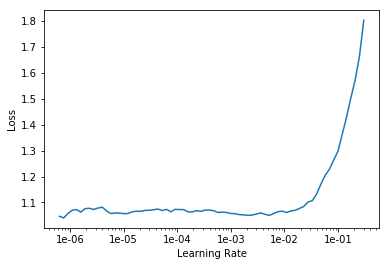

In [108]:
plant_celllearn_101.recorder.plot()

In [109]:
plant_celllearn_101.fit_one_cycle(5, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy
1,1.077882,2.504038,0.638989
2,1.061860,2.155650,0.644404
3,1.050650,2.655125,0.642599
4,1.052718,1.896884,0.645307
5,1.051202,2.731063,0.641697


In [110]:
plant_celllearn_101.unfreeze()

In [111]:
plant_celllearn_101.fit_one_cycle(5, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy
1,1.060642,2.905889,0.651625
2,1.053942,2.289418,0.659747
3,1.033062,1.748864,0.661552
4,1.005065,1.890320,0.665162
5,0.986365,1.877560,0.657942


In [ ]:
plant_celllearn_101.save('stage-1-plant_celllearn_101-fast_ai')

In [121]:
plant_celllearn_101 = create_cnn(data_2, models.resnet101, metrics=accuracy,pretrained=True, ps =0.3)

In [122]:
plant_celllearn_101.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy
1,2.074518,3.909638,0.442238
2,1.665645,5.922854,0.547834
3,1.368348,8.115802,0.606498
4,1.195349,2.403517,0.661552
5,1.088526,2.841278,0.632671


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


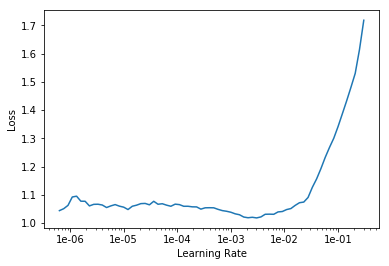

In [123]:
plant_celllearn_101.lr_find()
plant_celllearn_101.recorder.plot()

In [124]:
plant_celllearn_101.unfreeze()

In [125]:
plant_celllearn_101.fit_one_cycle(50, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy
1,1.028410,2.371086,0.637184
2,1.013930,3.149672,0.653430
3,1.025149,4.180013,0.647112
4,1.018981,2.495804,0.664260
5,1.002474,2.456010,0.655235
6,1.026318,3.675451,0.662455
7,0.998480,2.461931,0.665162
8,0.982882,2.620922,0.670578
9,0.969852,2.571089,0.677798
10,0.946084,2.199595,0.678700


In [126]:
plant_celllearn_101.save('stage-2-plant_celllearn_101-fast_ai')

In [127]:
plant_celllearn_101 = create_cnn(data_2, models.resnet101, metrics=accuracy,pretrained=True, ps =0.6)

In [128]:
plant_celllearn_101.load('stage-2-plant_celllearn_101-fast_ai')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (4436 items)
[Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (4436 items)
[Image (3, 920, 920), Image (3, 744, 744), Image (3, 1289, 1289), Image (3, 511, 511), Image (3, 1546, 1546)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Valid: LabelList
y: CategoryList (1108 items)
[Category Shepherds Purse, Category Common wheat, Category test, Category Sugar beet, Category Common Chickweed]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (1108 items)
[Image (3, 399, 399), Image (3, 113, 113), Image (3, 280, 280), Image (3, 611, 611), Image (3, 140, 140)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), st

In [129]:
plant_celllearn_101.unfreeze()

In [130]:
plant_celllearn_101.fit_one_cycle(50, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy
1,0.702043,1.628702,0.765343
2,0.703103,2.522598,0.764440
3,0.708274,1.488770,0.771661
4,0.693837,1.747475,0.763538
5,0.716857,3.153112,0.761733
6,0.690274,1.661952,0.773466
7,0.672915,2.123059,0.769856
8,0.674624,1.805525,0.765343
9,0.659488,2.612635,0.774368
10,0.656444,2.143680,0.775271


In [131]:
plant_celllearn_101.save('stage-3-plant_celllearn_101-fast_ai')

In [9]:
tfms_3 = get_transforms(flip_vert=True, max_lighting=0.7, max_warp=0.)

data_3 = (src_plant.transform(tfms_3, bs=32, size=128)
        .databunch().normalize(imagenet_stats))
data_3.classes
data_3.c

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet',
 'test']

13

In [10]:
plant_celllearn_101 = create_cnn(data_3, models.resnet101, metrics=accuracy,pretrained=True, ps =0.6)


In [12]:
plant_celllearn_101.load('stage-3-plant_celllearn_101-fast_ai')
plant_celllearn_101.freeze()


Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (4436 items)
[Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (4436 items)
[Image (3, 920, 920), Image (3, 744, 744), Image (3, 1289, 1289), Image (3, 511, 511), Image (3, 1546, 1546)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Valid: LabelList
y: CategoryList (1108 items)
[Category Shepherds Purse, Category Common wheat, Category test, Category Sugar beet, Category Common Chickweed]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (1108 items)
[Image (3, 399, 399), Image (3, 113, 113), Image (3, 280, 280), Image (3, 611, 611), Image (3, 140, 140)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), st

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


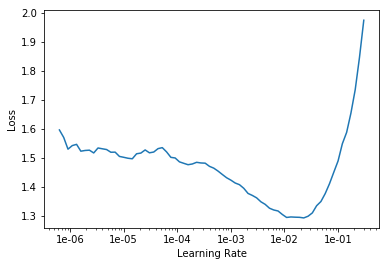

In [13]:
plant_celllearn_101.lr_find(); 
plant_celllearn_101.recorder.plot()

In [14]:
lr = 0.001 ## taken from min value in above plot
plant_celllearn_101.fit_one_cycle(5, slice(lr))


epoch,train_loss,valid_loss,accuracy
1,1.273801,0.705456,0.756318
2,0.965782,0.578433,0.805957
3,0.794045,0.529766,0.819495
4,0.707977,0.500952,0.821300
5,0.674271,0.486904,0.827617


In [15]:
plant_celllearn_101.save('stage-4-plant_celllearn_101-fast_ai')


In [22]:
plant_celllearn_101.load('stage-4-plant_celllearn_101-fast_ai')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (4436 items)
[Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (4436 items)
[Image (3, 920, 920), Image (3, 744, 744), Image (3, 1289, 1289), Image (3, 511, 511), Image (3, 1546, 1546)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Valid: LabelList
y: CategoryList (1108 items)
[Category Shepherds Purse, Category Common wheat, Category test, Category Sugar beet, Category Common Chickweed]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (1108 items)
[Image (3, 399, 399), Image (3, 113, 113), Image (3, 280, 280), Image (3, 611, 611), Image (3, 140, 140)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), st

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


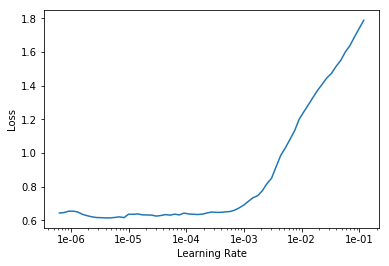

In [23]:
plant_celllearn_101.unfreeze()
plant_celllearn_101.lr_find()
plant_celllearn_101.recorder.plot()

In [24]:
plant_celllearn_101.fit_one_cycle(10, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy
1,0.639615,0.480373,0.830325
2,0.614938,0.427134,0.844765
3,0.567460,0.388133,0.856498
4,0.521975,0.385384,0.850181
5,0.468229,0.350321,0.855596
6,0.427255,0.352554,0.856498
7,0.399899,0.341631,0.869134
8,0.354911,0.337025,0.865523
9,0.342294,0.338792,0.864621
10,0.338738,0.332453,0.867329


In [25]:
plant_celllearn_101.save('stage-5-plant_celllearn_101-fast_ai')

In [27]:
def GenerateTestPredictionAndFile(Model,TestFileName):
    imagepreds = []
    fileids = []
    for file in os.listdir('/home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling/test/'):
        filename = os.path.join('/home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling/test/', file)
        imgtest = open_image(filename)
        predictionarray = Model.predict(imgtest)
        file
        str(predictionarray[0])
        fileids.append(file)
        imagepreds.append(str(predictionarray[0]))
    df = pd.DataFrame({'file':fileids, 'species':imagepreds})
    #df.to_csv(TestFileName, index=False,compression='gzip')
    df.to_csv(TestFileName, index=False)
    df.head()
    

## Progressive Resizing (128 > 256)

In [13]:
plant_celllearn_101.load('stage-5-plant_celllearn_101-fast_ai')
tfms_4 = get_transforms(flip_vert=True, max_lighting=0.7, max_warp=0.)

data_4 = (src_plant.transform(tfms_4, bs=16, size=256)
        .databunch().normalize(imagenet_stats))
data_4.classes
data_4.c
plant_celllearn_101.data = data_4
plant_celllearn_101.freeze()

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (4436 items)
[Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (4436 items)
[Image (3, 920, 920), Image (3, 744, 744), Image (3, 1289, 1289), Image (3, 511, 511), Image (3, 1546, 1546)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Valid: LabelList
y: CategoryList (1108 items)
[Category Shepherds Purse, Category Common wheat, Category test, Category Sugar beet, Category Common Chickweed]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (1108 items)
[Image (3, 399, 399), Image (3, 113, 113), Image (3, 280, 280), Image (3, 611, 611), Image (3, 140, 140)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), st

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet',
 'test']

13

In [14]:
plant_celllearn_101.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


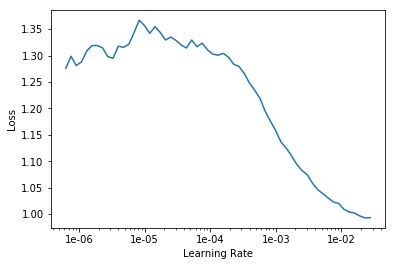

In [30]:
plant_celllearn_101.recorder.plot()

In [13]:
lr=1e-2

In [16]:
plant_celllearn_101.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy
1,0.663157,0.454550,0.833032
2,0.635842,0.435946,0.846570
3,0.568636,0.320552,0.881769
4,0.458733,0.318090,0.872744
5,0.380837,0.301786,0.875451


In [17]:
plant_celllearn_101.save('stage-6-plant_celllearn_101-fast_ai')

In [11]:
plant_celllearn_101.load('stage-6-plant_celllearn_101-fast_ai')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (4436 items)
[Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (4436 items)
[Image (3, 920, 920), Image (3, 744, 744), Image (3, 1289, 1289), Image (3, 511, 511), Image (3, 1546, 1546)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Valid: LabelList
y: CategoryList (1108 items)
[Category Shepherds Purse, Category Common wheat, Category test, Category Sugar beet, Category Common Chickweed]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (1108 items)
[Image (3, 399, 399), Image (3, 113, 113), Image (3, 280, 280), Image (3, 611, 611), Image (3, 140, 140)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), st

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


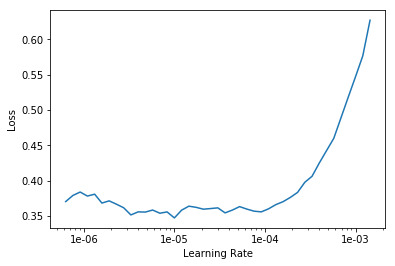

In [18]:
plant_celllearn_101.unfreeze()
plant_celllearn_101.lr_find()
plant_celllearn_101.recorder.plot()

In [15]:
plant_celllearn_101.fit_one_cycle(5, slice(1e-06, lr/5))

epoch,train_loss,valid_loss,accuracy
1,0.404771,0.440759,0.841155
2,0.416962,0.392799,0.851083
3,0.389532,0.401776,0.851083
4,0.360950,0.405737,0.849278
5,0.356724,0.372481,0.851986


In [16]:
plant_celllearn_101.unfreeze()

In [18]:
plant_celllearn_101.fit_one_cycle(5, slice(1e-06, lr/5))

epoch,train_loss,valid_loss,accuracy
1,0.450872,0.400466,0.853791
2,0.413911,0.363405,0.868231
3,0.384865,0.347087,0.874549
4,0.331076,0.331887,0.868231
5,0.291549,0.356372,0.858303


In [19]:
plant_celllearn_101.fit_one_cycle(2, slice(1e-06, lr/5))

epoch,train_loss,valid_loss,accuracy
1,0.313540,0.389306,0.848375
2,0.314102,0.369895,0.865523


In [20]:
plant_celllearn_101.save('stage-7-plant_celllearn_101-fast_ai')

In [21]:
plant_celllearn_101.load('stage-6-plant_celllearn_101-fast_ai')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (4436 items)
[Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (4436 items)
[Image (3, 920, 920), Image (3, 744, 744), Image (3, 1289, 1289), Image (3, 511, 511), Image (3, 1546, 1546)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Valid: LabelList
y: CategoryList (1108 items)
[Category Shepherds Purse, Category Common wheat, Category test, Category Sugar beet, Category Common Chickweed]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (1108 items)
[Image (3, 399, 399), Image (3, 113, 113), Image (3, 280, 280), Image (3, 611, 611), Image (3, 140, 140)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), st

[('test', 'Common Chickweed', 26),
 ('test', 'Loose Silky-bent', 24),
 ('test', 'Fat Hen', 19),
 ('Loose Silky-bent', 'test', 18),
 ('test', 'Scentless Mayweed', 16),
 ('test', 'Sugar beet', 16),
 ('Scentless Mayweed', 'Shepherds Purse', 15),
 ('Black-grass', 'Loose Silky-bent', 14),
 ('Loose Silky-bent', 'Black-grass', 12),
 ('test', 'Charlock', 12),
 ('test', 'Small-flowered Cranesbill', 11),
 ('Small-flowered Cranesbill', 'Common Chickweed', 10),
 ('test', 'Shepherds Purse', 9),
 ('test', 'Cleavers', 8),
 ('Scentless Mayweed', 'test', 7),
 ('Shepherds Purse', 'Common Chickweed', 7),
 ('test', 'Black-grass', 7),
 ('Sugar beet', 'test', 6),
 ('test', 'Common wheat', 6),
 ('Scentless Mayweed', 'Common Chickweed', 5),
 ('test', 'Maize', 5),
 ('Common wheat', 'Fat Hen', 3),
 ('Sugar beet', 'Shepherds Purse', 3),
 ('Black-grass', 'test', 2),
 ('Charlock', 'Fat Hen', 2),
 ('Cleavers', 'Common Chickweed', 2),
 ('Common Chickweed', 'test', 2),
 ('Common wheat', 'Sugar beet', 2),
 ('Common wh

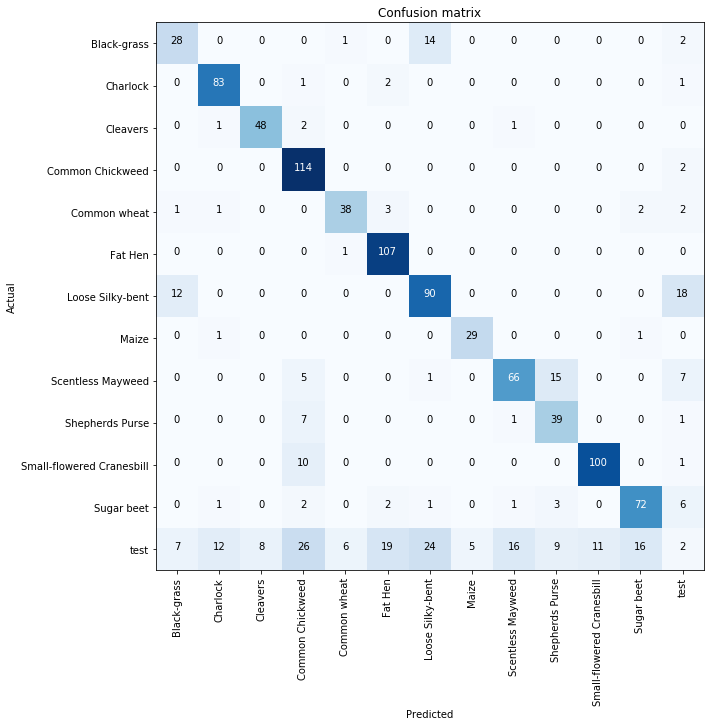

In [22]:
interp = ClassificationInterpretation.from_learner(plant_celllearn_101)
interp.plot_confusion_matrix(figsize=(10,10))
interp.most_confused()

In [32]:
#GenerateTestPredictionAndFile(plant_celllearn_101,'baseline_1plant_seedling_fast_ai_resnet.csv')
imagepreds = []
fileids = []
for file in os.listdir('/home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling/test/'):
    filename = os.path.join('/home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling/test/', file)
    imgtest = open_image(filename)
    predictionarray = plant_celllearn_101.predict(imgtest)
    file
    str(predictionarray[0])
    fileids.append(file)
    imagepreds.append(str(predictionarray[0]))
df = pd.DataFrame({'file':fileids, 'species':imagepreds})
#df.to_csv(TestFileName, index=False,compression='gzip')
df.to_csv('baseline_1plant_seedling_fast_ai_resnet.csv', index=False)
df.head()
    

'76dbd1054.png'

'Scentless Mayweed'

'9d3cb4745.png'

'Common wheat'

'e9cd91682.png'

'Common Chickweed'

'14bb43eee.png'

'Common wheat'

'6bce55e05.png'

'Cleavers'

'808cf55c6.png'

'Shepherds Purse'

'406ecb5c5.png'

'Charlock'

'b7a7f6390.png'

'Fat Hen'

'caa2fbd79.png'

'Common Chickweed'

'172f9b10b.png'

'Common Chickweed'

'a8de7c1b7.png'

'Loose Silky-bent'

'7c85b0265.png'

'Loose Silky-bent'

'a9d2eab61.png'

'Loose Silky-bent'

'37714071b.png'

'Common Chickweed'

'ad12382d4.png'

'Loose Silky-bent'

'4049a6ea6.png'

'Loose Silky-bent'

'e15472085.png'

'Common Chickweed'

'606647f64.png'

'Common Chickweed'

'9baf94467.png'

'Sugar beet'

'39b740f7e.png'

'Loose Silky-bent'

'80e299ae9.png'

'Shepherds Purse'

'25a4c427e.png'

'Loose Silky-bent'

'55251925f.png'

'Common Chickweed'

'592cc5b89.png'

'Loose Silky-bent'

'17529c555.png'

'Scentless Mayweed'

'a800caead.png'

'Sugar beet'

'c74c5b7fc.png'

'Shepherds Purse'

'6b9d6f8c9.png'

'Sugar beet'

'a8da9c08d.png'

'Charlock'

'e721c6ac8.png'

'Black-grass'

'1c52ea820.png'

'Fat Hen'

'33748968f.png'

'Cleavers'

'5ee9d0a5b.png'

'Loose Silky-bent'

'24dbc3b21.png'

'Sugar beet'

'8f523520c.png'

'Shepherds Purse'

'9b4800b42.png'

'Charlock'

'b573b7a56.png'

'Loose Silky-bent'

'4f83143e1.png'

'Maize'

'aaf4da98f.png'

'Sugar beet'

'bb1d1bfd3.png'

'Cleavers'

'65d08b894.png'

'test'

'd102e1a15.png'

'Cleavers'

'a19c3faca.png'

'Common Chickweed'

'c7eb96871.png'

'Common wheat'

'bebcaab66.png'

'Scentless Mayweed'

'05341a8a6.png'

'Scentless Mayweed'

'6da892be6.png'

'Small-flowered Cranesbill'

'e96e57a90.png'

'Shepherds Purse'

'08d591441.png'

'Common Chickweed'

'5eb9c26a6.png'

'Loose Silky-bent'

'0e8492cb1.png'

'Sugar beet'

'bf3924a57.png'

'Common Chickweed'

'b5c7fd009.png'

'Loose Silky-bent'

'c5078bac5.png'

'test'

'785a73ab8.png'

'Common Chickweed'

'29bab7cad.png'

'Common Chickweed'

'e783f5a4f.png'

'Sugar beet'

'dce2f6612.png'

'Common Chickweed'

'00ef713a8.png'

'Common Chickweed'

'f6d250856.png'

'Common Chickweed'

'24c94a6ca.png'

'Sugar beet'

'8a30b2de3.png'

'Common wheat'

'dcd7ff249.png'

'Scentless Mayweed'

'0c27cf05f.png'

'Scentless Mayweed'

'593896f83.png'

'Common Chickweed'

'd2f422ccb.png'

'Common Chickweed'

'3f64c2c1b.png'

'Common wheat'

'7615e52d3.png'

'Cleavers'

'486e59179.png'

'Common Chickweed'

'9aa5587fe.png'

'Loose Silky-bent'

'219fd68d5.png'

'Scentless Mayweed'

'a35fd6fbb.png'

'Common Chickweed'

'4b032563b.png'

'Common Chickweed'

'126a71ce0.png'

'Charlock'

'187668bde.png'

'Scentless Mayweed'

'71f5323c5.png'

'Loose Silky-bent'

'8e6ec1ca6.png'

'Small-flowered Cranesbill'

'46c14fde2.png'

'Loose Silky-bent'

'0c5f6c493.png'

'Loose Silky-bent'

'0086a6340.png'

'Common Chickweed'

'429211ee6.png'

'Fat Hen'

'506347cfe.png'

'Shepherds Purse'

'ffc6f8527.png'

'Common wheat'

'86c309150.png'

'test'

'089ad62a7.png'

'Common Chickweed'

'36839d5e9.png'

'Scentless Mayweed'

'756dd5070.png'

'Common Chickweed'

'fd87b36ae.png'

'Loose Silky-bent'

'cf46d09c5.png'

'Common Chickweed'

'2693e5c65.png'

'Maize'

'c0461776c.png'

'Common Chickweed'

'8585f9718.png'

'Loose Silky-bent'

'65e97117e.png'

'Loose Silky-bent'

'8d6991365.png'

'Black-grass'

'd84d37a61.png'

'Common Chickweed'

'6ba4ef411.png'

'Common Chickweed'

'589e643b8.png'

'Shepherds Purse'

'686dc7ec8.png'

'Black-grass'

'8c9953903.png'

'Fat Hen'

'19fdf19fb.png'

'Common wheat'

'5ca0205f9.png'

'Charlock'

'cb76a7766.png'

'Fat Hen'

'0ebf8f2f4.png'

'Maize'

'7d22abf91.png'

'Scentless Mayweed'

'a935ca110.png'

'Loose Silky-bent'

'618de3d7a.png'

'Charlock'

'4e69d100a.png'

'Common Chickweed'

'a1da8be3c.png'

'Maize'

'6edb96d45.png'

'Maize'

'df11d56a7.png'

'Sugar beet'

'c5e88cd42.png'

'Common Chickweed'

'668c1007c.png'

'Charlock'

'd41d87796.png'

'Scentless Mayweed'

'cae684f8f.png'

'Charlock'

'699d3c707.png'

'Sugar beet'

'085974290.png'

'Scentless Mayweed'

'490c4f9c8.png'

'Fat Hen'

'8455169fe.png'

'Common wheat'

'fda39e16f.png'

'Loose Silky-bent'

'6df8e31ea.png'

'Charlock'

'd488a4fe1.png'

'Common wheat'

'856f2910a.png'

'Small-flowered Cranesbill'

'3f92d8039.png'

'Black-grass'

'07e62f903.png'

'Maize'

'd93c7ab6d.png'

'Loose Silky-bent'

'a1e0a6c02.png'

'Cleavers'

'b1cd2a91e.png'

'Shepherds Purse'

'f4caf74f9.png'

'Charlock'

'043449b0b.png'

'test'

'f445fe6fb.png'

'Charlock'

'f351ce097.png'

'Loose Silky-bent'

'e73e308be.png'

'Fat Hen'

'e1a0e3202.png'

'Loose Silky-bent'

'7cabd68cc.png'

'Loose Silky-bent'

'f4ad9d950.png'

'Sugar beet'

'3fbd0fc6a.png'

'Common Chickweed'

'da5255450.png'

'Common Chickweed'

'4a337a4a9.png'

'Fat Hen'

'827279bad.png'

'Scentless Mayweed'

'1b490196c.png'

'Shepherds Purse'

'632156793.png'

'Cleavers'

'd14aa43f3.png'

'Small-flowered Cranesbill'

'0c51bf229.png'

'Maize'

'ab35453cb.png'

'Cleavers'

'0f6cbe5e8.png'

'Maize'

'9a3f20121.png'

'Loose Silky-bent'

'48d97c645.png'

'Small-flowered Cranesbill'

'2d5058a59.png'

'Common Chickweed'

'dc55449b2.png'

'Sugar beet'

'1459e96a0.png'

'Cleavers'

'ae90f2827.png'

'Common Chickweed'

'966ae5ad9.png'

'Loose Silky-bent'

'9b9911f20.png'

'Scentless Mayweed'

'c4ed8ed38.png'

'Charlock'

'03e322a29.png'

'Sugar beet'

'edfdb4aeb.png'

'Scentless Mayweed'

'4ea7493d5.png'

'Sugar beet'

'19b51843a.png'

'Common Chickweed'

'721b2c47a.png'

'Fat Hen'

'7b21ba6ba.png'

'Common Chickweed'

'dfb1d9012.png'

'Loose Silky-bent'

'af45e222a.png'

'Scentless Mayweed'

'958bb9e96.png'

'Charlock'

'e98e5d1d5.png'

'Black-grass'

'063363305.png'

'Small-flowered Cranesbill'

'c60e91e07.png'

'Loose Silky-bent'

'99569b224.png'

'Common wheat'

'fe29629fb.png'

'Scentless Mayweed'

'38c054379.png'

'Common Chickweed'

'9d79a1f0c.png'

'Small-flowered Cranesbill'

'adb7a032c.png'

'Loose Silky-bent'

'da231c97f.png'

'Scentless Mayweed'

'cf90fc52d.png'

'Maize'

'8cf2e3e6c.png'

'Common Chickweed'

'b026bf8ca.png'

'Loose Silky-bent'

'9fab816f2.png'

'Fat Hen'

'ef74dbcad.png'

'Scentless Mayweed'

'ce15eee52.png'

'Charlock'

'36d62bf36.png'

'Common wheat'

'33317fc2a.png'

'Fat Hen'

'9326bda1b.png'

'Common Chickweed'

'76555b064.png'

'Loose Silky-bent'

'8c98a6e9b.png'

'Black-grass'

'b4c3df835.png'

'Maize'

'c2de6020a.png'

'Small-flowered Cranesbill'

'9c32a797e.png'

'Common wheat'

'61b044411.png'

'Loose Silky-bent'

'ec08a5d56.png'

'Small-flowered Cranesbill'

'31fcdc161.png'

'Maize'

'a254d71f6.png'

'Black-grass'

'752101fdf.png'

'Small-flowered Cranesbill'

'b7ad92859.png'

'Common Chickweed'

'85431c075.png'

'Loose Silky-bent'

'60fea2ef6.png'

'Sugar beet'

'2d9c798f9.png'

'Small-flowered Cranesbill'

'd2f0f326e.png'

'Common Chickweed'

'42e7ed442.png'

'Common Chickweed'

'0ee4ad224.png'

'Shepherds Purse'

'1fefb54b7.png'

'Fat Hen'

'241e6935a.png'

'Sugar beet'

'592473c83.png'

'Black-grass'

'55fed435f.png'

'Maize'

'22e79540f.png'

'Cleavers'

'1be0713da.png'

'Cleavers'

'74fd477eb.png'

'Common Chickweed'

'a85b48a95.png'

'Scentless Mayweed'

'b0acaff4a.png'

'Black-grass'

'a74d475c2.png'

'Common Chickweed'

'446f7da01.png'

'Loose Silky-bent'

'fea1d13d6.png'

'Common Chickweed'

'279df95f2.png'

'Sugar beet'

'3f826b318.png'

'Common Chickweed'

'd09d24c58.png'

'Loose Silky-bent'

'b3e08b037.png'

'Fat Hen'

'7fdb7202d.png'

'Scentless Mayweed'

'dd9f36df7.png'

'Small-flowered Cranesbill'

'e84464f5a.png'

'Cleavers'

'3d65168c2.png'

'Common Chickweed'

'ace8761dd.png'

'Common Chickweed'

'770a265f5.png'

'Small-flowered Cranesbill'

'003d61042.png'

'Fat Hen'

'b4f7c9214.png'

'Loose Silky-bent'

'20817c846.png'

'Scentless Mayweed'

'b7192c70f.png'

'Common wheat'

'b6a3f7876.png'

'Black-grass'

'00c47e980.png'

'Sugar beet'

'54b3afd58.png'

'Cleavers'

'8a4d3a1b1.png'

'Loose Silky-bent'

'59c6a9f95.png'

'Fat Hen'

'664194d19.png'

'Common Chickweed'

'523e5505c.png'

'Fat Hen'

'cd6adba97.png'

'Small-flowered Cranesbill'

'52dc7a4d6.png'

'Common Chickweed'

'8e29abce1.png'

'Scentless Mayweed'

'1926e82fd.png'

'Loose Silky-bent'

'8d6acbe9b.png'

'Common Chickweed'

'5bdcfa329.png'

'Loose Silky-bent'

'e88bf0db9.png'

'Common Chickweed'

'23e480e64.png'

'Common Chickweed'

'59e1cea8d.png'

'Cleavers'

'54c8bb900.png'

'Charlock'

'55a852f40.png'

'Common Chickweed'

'9cce7328c.png'

'Loose Silky-bent'

'5bd71f445.png'

'Common Chickweed'

'4e1190d78.png'

'Black-grass'

'590f5aea6.png'

'Charlock'

'11d3f68ff.png'

'Loose Silky-bent'

'539961189.png'

'Common Chickweed'

'0021e90e4.png'

'Small-flowered Cranesbill'

'8a8d6c712.png'

'Cleavers'

'897e5a8de.png'

'Cleavers'

'5a6bf96f6.png'

'Maize'

'03a2ee656.png'

'Small-flowered Cranesbill'

'5c3cd7ea2.png'

'Scentless Mayweed'

'41e07778c.png'

'Cleavers'

'1758a1baf.png'

'Common Chickweed'

'835dc5447.png'

'Small-flowered Cranesbill'

'223e4af09.png'

'Cleavers'

'1694a70e4.png'

'Scentless Mayweed'

'19e58cc5e.png'

'Common Chickweed'

'78c5fba1d.png'

'test'

'90b595f12.png'

'Common Chickweed'

'63c07d340.png'

'Sugar beet'

'5e6a237f2.png'

'Fat Hen'

'cec5bf198.png'

'Cleavers'

'1364b297a.png'

'Cleavers'

'fadc6adbc.png'

'Charlock'

'a83820a2c.png'

'Sugar beet'

'f1f7c833f.png'

'Shepherds Purse'

'3efa1f66c.png'

'Loose Silky-bent'

'f4021df6c.png'

'Fat Hen'

'0caeda5df.png'

'Common wheat'

'b341d0aab.png'

'Common Chickweed'

'e0ec5b6a1.png'

'Sugar beet'

'4823c3ffa.png'

'Scentless Mayweed'

'0ad9e7dfb.png'

'Sugar beet'

'a8388a37f.png'

'Fat Hen'

'a0b393945.png'

'Small-flowered Cranesbill'

'e901b0f28.png'

'Fat Hen'

'33448fe39.png'

'Loose Silky-bent'

'74068643d.png'

'Loose Silky-bent'

'c35efa095.png'

'Scentless Mayweed'

'c10db7ae2.png'

'Maize'

'dc4cd56a3.png'

'Black-grass'

'ef7a5651d.png'

'Scentless Mayweed'

'377283a21.png'

'Maize'

'afa446484.png'

'Small-flowered Cranesbill'

'8e3ed0a25.png'

'Small-flowered Cranesbill'

'8cf909eb3.png'

'Charlock'

'3526b05cc.png'

'Scentless Mayweed'

'd17f48d3b.png'

'Scentless Mayweed'

'f4e7733d4.png'

'Small-flowered Cranesbill'

'c10ccbd82.png'

'Scentless Mayweed'

'604dd663f.png'

'Shepherds Purse'

'653193c1a.png'

'Common wheat'

'b30ab4659.png'

'Cleavers'

'270b939cf.png'

'Common Chickweed'

'1541bdb2e.png'

'Maize'

'a74bf916d.png'

'Shepherds Purse'

'e19673dc9.png'

'Charlock'

'a8b431a3e.png'

'Sugar beet'

'b39c71707.png'

'Maize'

'2a667e099.png'

'Fat Hen'

'dabe3e5be.png'

'Small-flowered Cranesbill'

'1191ba346.png'

'Cleavers'

'5a38ac566.png'

'Loose Silky-bent'

'19618ad6a.png'

'Fat Hen'

'41f1c3cdb.png'

'Fat Hen'

'8cfd98117.png'

'Scentless Mayweed'

'a544fc46d.png'

'Scentless Mayweed'

'8ca6140ca.png'

'Loose Silky-bent'

'e5881dd33.png'

'Fat Hen'

'79dafec17.png'

'Loose Silky-bent'

'8ab8a958b.png'

'Fat Hen'

'02cfeb38d.png'

'Loose Silky-bent'

'0885e7690.png'

'Shepherds Purse'

'29ce426a1.png'

'Common Chickweed'

'73260a4ee.png'

'Fat Hen'

'df521c0c0.png'

'Loose Silky-bent'

'b98327bf4.png'

'Scentless Mayweed'

'cadab6616.png'

'Shepherds Purse'

'f9f35cbd4.png'

'Common Chickweed'

'24a058589.png'

'Charlock'

'cf3a8b2fd.png'

'Black-grass'

'f3fcfff1b.png'

'Cleavers'

'b130a0632.png'

'Cleavers'

'2f246d688.png'

'Small-flowered Cranesbill'

'f593c9cf0.png'

'Sugar beet'

'71b232519.png'

'Black-grass'

'e4d5ec761.png'

'Black-grass'

'4c5ab9b68.png'

'Cleavers'

'6d6eb3830.png'

'Shepherds Purse'

'67ce3eaa6.png'

'Small-flowered Cranesbill'

'e19ad6ac9.png'

'Charlock'

'f8318faf1.png'

'Shepherds Purse'

'ef3e232ad.png'

'Common Chickweed'

'ac3193f78.png'

'Common Chickweed'

'd689256be.png'

'Common wheat'

'1dc7c45df.png'

'Loose Silky-bent'

'c50335991.png'

'Fat Hen'

'fc6f686fb.png'

'Sugar beet'

'a2c89c367.png'

'Charlock'

'eaf0815e2.png'

'Small-flowered Cranesbill'

'35a90f8d0.png'

'Scentless Mayweed'

'148bbda66.png'

'Charlock'

'48ef6a2ff.png'

'Common wheat'

'974959ec1.png'

'Common wheat'

'97b2f0a10.png'

'Small-flowered Cranesbill'

'8104422bb.png'

'Common Chickweed'

'e1809cef2.png'

'Scentless Mayweed'

'3a909ead8.png'

'Small-flowered Cranesbill'

'4bbfd1e05.png'

'Cleavers'

'26852751a.png'

'Charlock'

'cbba27d89.png'

'Maize'

'aecfaed64.png'

'Common Chickweed'

'a0f37c726.png'

'Small-flowered Cranesbill'

'550a8b7e6.png'

'Common Chickweed'

'c75a82234.png'

'Scentless Mayweed'

'0751c0bbc.png'

'Sugar beet'

'3da774107.png'

'Fat Hen'

'61dd2cdc5.png'

'Common wheat'

'8a32d0bfa.png'

'Small-flowered Cranesbill'

'67e185673.png'

'Small-flowered Cranesbill'

'acdb75e00.png'

'Loose Silky-bent'

'f23faf9c1.png'

'Loose Silky-bent'

'1623fb9e1.png'

'Fat Hen'

'6049234e6.png'

'Fat Hen'

'8170d33c1.png'

'Maize'

'205df1df3.png'

'Common Chickweed'

'20ea96bcc.png'

'Fat Hen'

'f66ae4070.png'

'Maize'

'59b2c6f2b.png'

'Common Chickweed'

'd0152bd7c.png'

'Fat Hen'

'ef65533d5.png'

'Loose Silky-bent'

'165681fd9.png'

'Shepherds Purse'

'466bb6d3b.png'

'test'

'3bbef3ecb.png'

'Scentless Mayweed'

'ef02b4ee7.png'

'Sugar beet'

'98062cd87.png'

'Common Chickweed'

'5f04aed97.png'

'Small-flowered Cranesbill'

'7d3045fc3.png'

'Sugar beet'

'976e4e079.png'

'Common Chickweed'

'7696badea.png'

'Loose Silky-bent'

'e5297b675.png'

'Loose Silky-bent'

'969a851be.png'

'Scentless Mayweed'

'728eabae1.png'

'Charlock'

'862b8e7a0.png'

'Sugar beet'

'60ee66ddd.png'

'Cleavers'

'65489944f.png'

'Shepherds Purse'

'47b7d8e17.png'

'Small-flowered Cranesbill'

'5883b423d.png'

'Scentless Mayweed'

'03566743d.png'

'Fat Hen'

'5b3beec58.png'

'Loose Silky-bent'

'24d36c52c.png'

'Common Chickweed'

'a2d25b4f3.png'

'Common Chickweed'

'2dd5cfba9.png'

'Common Chickweed'

'391dcd7fd.png'

'Loose Silky-bent'

'0ae6668fa.png'

'Loose Silky-bent'

'dd5ec63d9.png'

'Sugar beet'

'82b5f4d33.png'

'Shepherds Purse'

'cc74feadc.png'

'test'

'3b73c3b61.png'

'Black-grass'

'060450d79.png'

'Common Chickweed'

'f85ed9b6d.png'

'Shepherds Purse'

'0c45ace27.png'

'Common Chickweed'

'bfab3e3d0.png'

'Sugar beet'

'8e2e5604e.png'

'Sugar beet'

'abf8b0772.png'

'Scentless Mayweed'

'4b155fb07.png'

'Maize'

'5af1d74ee.png'

'Sugar beet'

'99036c51d.png'

'Loose Silky-bent'

'a890ac088.png'

'Charlock'

'659412b1a.png'

'Loose Silky-bent'

'22fbf13d6.png'

'Loose Silky-bent'

'3e9f41817.png'

'Loose Silky-bent'

'd89db156f.png'

'Common Chickweed'

'4bbf1f6ea.png'

'Shepherds Purse'

'7506c0c02.png'

'Scentless Mayweed'

'30ad31220.png'

'Charlock'

'be341dbdc.png'

'Loose Silky-bent'

'6db684fff.png'

'Scentless Mayweed'

'35cf9fa01.png'

'Shepherds Purse'

'55920f07f.png'

'Maize'

'b6f3d8b5d.png'

'Scentless Mayweed'

'177d7e2a4.png'

'Common Chickweed'

'04814f36d.png'

'Scentless Mayweed'

'abc331628.png'

'Common wheat'

'c06e7c748.png'

'Scentless Mayweed'

'f0ffa00bd.png'

'Sugar beet'

'c0f5d9ac8.png'

'Common Chickweed'

'ce42adffb.png'

'Loose Silky-bent'

'3ebbe9ca4.png'

'Charlock'

'9c8b08a24.png'

'Loose Silky-bent'

'ab0f67743.png'

'Loose Silky-bent'

'647689543.png'

'Loose Silky-bent'

'cb496f36e.png'

'Black-grass'

'ff65bc002.png'

'Charlock'

'8b9144917.png'

'Common Chickweed'

'675ec1b0b.png'

'Small-flowered Cranesbill'

'87608f7aa.png'

'Charlock'

'7b52585da.png'

'Scentless Mayweed'

'5296835a0.png'

'Small-flowered Cranesbill'

'98d819587.png'

'Shepherds Purse'

'780defa2e.png'

'Common Chickweed'

'837ac0270.png'

'Scentless Mayweed'

'65e262a6d.png'

'Charlock'

'808578ed5.png'

'Charlock'

'd01873fdd.png'

'Loose Silky-bent'

'410e6f702.png'

'Small-flowered Cranesbill'

'35ebe165c.png'

'Black-grass'

'26e7ae885.png'

'Fat Hen'

'c7b07431e.png'

'Scentless Mayweed'

'0bf7bfb05.png'

'Black-grass'

'bb64660b7.png'

'Sugar beet'

'b62dca166.png'

'Fat Hen'

'a85fc8c9a.png'

'Small-flowered Cranesbill'

'953496deb.png'

'Fat Hen'

'31f3dd81f.png'

'Loose Silky-bent'

'ef9676433.png'

'Charlock'

'd6c8c3c48.png'

'Small-flowered Cranesbill'

'4e9d3765f.png'

'Charlock'

'a55d26a4c.png'

'Common Chickweed'

'c0d9e170b.png'

'Small-flowered Cranesbill'

'17a78fb44.png'

'Common wheat'

'32a8c8a1d.png'

'Loose Silky-bent'

'75cb95e91.png'

'Charlock'

'3abb502fb.png'

'Loose Silky-bent'

'79fba50db.png'

'Common Chickweed'

'be2499cf4.png'

'Black-grass'

'ac75d3326.png'

'Loose Silky-bent'

'995c7ab1e.png'

'test'

'5b63dcc21.png'

'Common Chickweed'

'6edc76e7c.png'

'Fat Hen'

'fda0b5c38.png'

'Common wheat'

'6a41bf95b.png'

'Scentless Mayweed'

'e5368474f.png'

'Scentless Mayweed'

'87f627bf9.png'

'Common Chickweed'

'79d93bc96.png'

'Loose Silky-bent'

'16fd2e01a.png'

'Small-flowered Cranesbill'

'17d5e5ac4.png'

'Loose Silky-bent'

'fd925f542.png'

'Common Chickweed'

'12625488b.png'

'Fat Hen'

'beebe5f4e.png'

'Scentless Mayweed'

'9c777333d.png'

'Common Chickweed'

'6908fb540.png'

'Sugar beet'

'5779fe8b4.png'

'Fat Hen'

'69d1669f8.png'

'Charlock'

'd7017f701.png'

'Fat Hen'

'59f62ad1d.png'

'Black-grass'

'e14afa235.png'

'Common wheat'

'1bf9b94a6.png'

'Scentless Mayweed'

'bd72d4d8a.png'

'Scentless Mayweed'

'cc3d2a59a.png'

'Sugar beet'

'c88ebfb47.png'

'Small-flowered Cranesbill'

'0911d3dee.png'

'Common Chickweed'

'0c4199daa.png'

'Loose Silky-bent'

'8ece6efec.png'

'Scentless Mayweed'

'4c8005bbc.png'

'Black-grass'

'f9ea23fb5.png'

'Fat Hen'

'de0b79659.png'

'Fat Hen'

'c63da993b.png'

'Sugar beet'

'1f3f44563.png'

'Maize'

'c7051c902.png'

'Common Chickweed'

'8303b27ed.png'

'Loose Silky-bent'

'800a8c17e.png'

'Fat Hen'

'25fa8d109.png'

'Common wheat'

'1821eb11a.png'

'Scentless Mayweed'

'3185294c8.png'

'Scentless Mayweed'

'288564c76.png'

'Sugar beet'

'3eebd36c6.png'

'Charlock'

'd5f7dd60a.png'

'Scentless Mayweed'

'c0bc3997b.png'

'Scentless Mayweed'

'dabea05f4.png'

'Loose Silky-bent'

'bdde957ec.png'

'Scentless Mayweed'

'fd253a74e.png'

'Cleavers'

'615d2b0a9.png'

'Sugar beet'

'007b3da8b.png'

'Sugar beet'

'0437393b1.png'

'Fat Hen'

'44e8b8833.png'

'Small-flowered Cranesbill'

'a3b375b34.png'

'Loose Silky-bent'

'2ea664465.png'

'Sugar beet'

'da9ef7858.png'

'Charlock'

'aa7d098d1.png'

'Common Chickweed'

'8dbb8e1b9.png'

'Charlock'

'6b721f68e.png'

'Black-grass'

'e6f1211a2.png'

'Sugar beet'

'03ef36742.png'

'Scentless Mayweed'

'71334c634.png'

'Maize'

'239bdf640.png'

'Charlock'

'cfb18d262.png'

'Scentless Mayweed'

'3eda9cbb6.png'

'Scentless Mayweed'

'338c7e907.png'

'Charlock'

'6680836dd.png'

'Sugar beet'

'd350a25fa.png'

'Common Chickweed'

'8b27bfd2b.png'

'Small-flowered Cranesbill'

'b944a49ca.png'

'Loose Silky-bent'

'aee6fa3df.png'

'Loose Silky-bent'

'8faadb6a8.png'

'Sugar beet'

'2b55a2da2.png'

'Charlock'

'a7bd7cadb.png'

'Fat Hen'

'66ab0e8d0.png'

'Charlock'

'521b27a17.png'

'Loose Silky-bent'

'bea23d9f8.png'

'Shepherds Purse'

'71e73a8a0.png'

'Sugar beet'

'2e86f1085.png'

'Fat Hen'

'e52493d0b.png'

'Common wheat'

'56112b92c.png'

'Small-flowered Cranesbill'

'534e74d83.png'

'Maize'

'502dff972.png'

'test'

'6c874918c.png'

'Loose Silky-bent'

'e471f1d3a.png'

'Charlock'

'96ecad7a1.png'

'Small-flowered Cranesbill'

'8916793ce.png'

'Small-flowered Cranesbill'

'4287d810c.png'

'Common Chickweed'

'32b42c120.png'

'Small-flowered Cranesbill'

'3827436f3.png'

'Common Chickweed'

'fe9e87b78.png'

'Scentless Mayweed'

'd668409ff.png'

'Loose Silky-bent'

'7f46a71db.png'

'Sugar beet'

'df7cb5f87.png'

'Common Chickweed'

'cd5f0db1c.png'

'Small-flowered Cranesbill'

'd563be369.png'

'Fat Hen'

'0d117d910.png'

'Common Chickweed'

'78b1bf91a.png'

'Sugar beet'

'7f9e9565d.png'

'Scentless Mayweed'

'7f31c7f42.png'

'Loose Silky-bent'

'c64370a72.png'

'Sugar beet'

'c6b76307d.png'

'Cleavers'

'b03397525.png'

'Loose Silky-bent'

'060f1dc84.png'

'Common Chickweed'

'39858776a.png'

'Cleavers'

'16467a950.png'

'Loose Silky-bent'

'4e18ab737.png'

'Cleavers'

'b29339405.png'

'Black-grass'

'bf66b9cd2.png'

'Maize'

'a3d0031fd.png'

'Loose Silky-bent'

'9516e56c4.png'

'Black-grass'

'fba8fc78a.png'

'Loose Silky-bent'

'cfd8165e9.png'

'Charlock'

'099b961ec.png'

'Common Chickweed'

'56a01b835.png'

'Cleavers'

'6a47821f9.png'

'Loose Silky-bent'

'20e562fd5.png'

'Sugar beet'

'bb1c84bbc.png'

'Loose Silky-bent'

'50de8a115.png'

'Shepherds Purse'

'7beb2766f.png'

'Scentless Mayweed'

'25cf6eb73.png'

'Maize'

'8874bba69.png'

'Black-grass'

'2df78338c.png'

'Common Chickweed'

'a38b8a581.png'

'Small-flowered Cranesbill'

'0d31e6602.png'

'Small-flowered Cranesbill'

'da713c465.png'

'Black-grass'

'64fe8beb9.png'

'Scentless Mayweed'

'a276c65f7.png'

'Loose Silky-bent'

'd9c50616e.png'

'Sugar beet'

'a2b703e21.png'

'Small-flowered Cranesbill'

'8b043093d.png'

'Small-flowered Cranesbill'

'c1ecff98b.png'

'Loose Silky-bent'

'3281183f9.png'

'Scentless Mayweed'

'e5e3dccff.png'

'Common wheat'

'892e9d6c6.png'

'Scentless Mayweed'

'fea355851.png'

'Loose Silky-bent'

'248436078.png'

'Cleavers'

'fdea6b119.png'

'Black-grass'

'9df3275da.png'

'Small-flowered Cranesbill'

'8301b0547.png'

'Charlock'

'3d38a87bc.png'

'Loose Silky-bent'

'f9b6bfb00.png'

'Cleavers'

'a169b71e7.png'

'Charlock'

'7691014a1.png'

'Charlock'

'59358cd44.png'

'Small-flowered Cranesbill'

'f4234cf4f.png'

'Fat Hen'

'f2dc546ca.png'

'Cleavers'

'2d992d1fb.png'

'Loose Silky-bent'

'a060c1cf8.png'

'Maize'

'e7077322d.png'

'Scentless Mayweed'

'6dd095129.png'

'Common Chickweed'

'116b136de.png'

'Sugar beet'

'b47691c08.png'

'Scentless Mayweed'

'7a38416be.png'

'Charlock'

'824f5d4e5.png'

'test'

'8bc0261c9.png'

'Loose Silky-bent'

'9643fc5f4.png'

'Charlock'

'f48916a8c.png'

'Scentless Mayweed'

'1376f3b63.png'

'Loose Silky-bent'

'599691cd9.png'

'Small-flowered Cranesbill'

'c069fc3fa.png'

'Fat Hen'

'37297a64c.png'

'Common Chickweed'

'b3d6fdb80.png'

'Shepherds Purse'

'96f14d90c.png'

'Sugar beet'

'558aa7deb.png'

'Loose Silky-bent'

'851c90831.png'

'Loose Silky-bent'

'29f49cd0b.png'

'Fat Hen'

'2406d6c99.png'

'Common Chickweed'

'48231e475.png'

'Scentless Mayweed'

'79e5ea8fa.png'

'test'

'88ac6df54.png'

'Loose Silky-bent'

'8e4eaeec0.png'

'Common Chickweed'

'24d78df74.png'

'Common Chickweed'

'1d321253f.png'

'Fat Hen'

'809eb0b82.png'

'Charlock'

'cbe761896.png'

'Charlock'

'1b6a6494d.png'

'Sugar beet'

'948cdb277.png'

'Cleavers'

'1cfd91582.png'

'Charlock'

'754b1adf8.png'

'Small-flowered Cranesbill'

'a8c8a1db0.png'

'Common Chickweed'

'4bcdaa5e2.png'

'Shepherds Purse'

'bffc08672.png'

'Common Chickweed'

'4f44ca525.png'

'Common Chickweed'

'd515398fd.png'

'Loose Silky-bent'

'122913909.png'

'Maize'

'37c3108d6.png'

'Shepherds Purse'

'c5e419015.png'

'Scentless Mayweed'

'ce3d280eb.png'

'Common Chickweed'

'599c82eea.png'

'Scentless Mayweed'

'60f0bc617.png'

'Small-flowered Cranesbill'

'd2fd9df40.png'

'Loose Silky-bent'

'c6c8d4ba0.png'

'Loose Silky-bent'

'780bd2a2c.png'

'Sugar beet'

'1312065a5.png'

'Small-flowered Cranesbill'

'00d090cde.png'

'Loose Silky-bent'

'c85ef220d.png'

'Common Chickweed'

'fb022edf9.png'

'Common Chickweed'

'd8f4923f8.png'

'Common Chickweed'

'5bc6595f6.png'

'Maize'

'e921021a8.png'

'Fat Hen'

'fbf88b6be.png'

'Charlock'

'0dba99002.png'

'Sugar beet'

'8311740de.png'

'Fat Hen'

'fea3da57c.png'

'Sugar beet'

'0625f063b.png'

'Common Chickweed'

'1f5e5554e.png'

'Shepherds Purse'

'071cb3ece.png'

'Fat Hen'

'f25996db8.png'

'Small-flowered Cranesbill'

'a4b61a4ea.png'

'Loose Silky-bent'

'06d12f6fa.png'

'Shepherds Purse'

'c832e4302.png'

'Fat Hen'

'39d569be4.png'

'Loose Silky-bent'

'5bbc0a255.png'

'Common Chickweed'

'7d4cd07ad.png'

'Common Chickweed'

'e80a259c5.png'

'Common Chickweed'

'a006a475c.png'

'Common Chickweed'

'1d48b7564.png'

'Scentless Mayweed'

'13b9fa92d.png'

'Sugar beet'

'90d119d25.png'

'Scentless Mayweed'

'ede6b84b4.png'

'Cleavers'

'3d67c434b.png'

'Fat Hen'

'efe19dc32.png'

'Charlock'

'0a64e3e6c.png'

'Black-grass'

'01291174f.png'

'Fat Hen'

'd0cdc768f.png'

'Common wheat'

'2bd74d2da.png'

'Loose Silky-bent'

'9c0c5b731.png'

'Loose Silky-bent'

'86676d627.png'

'Fat Hen'

'5315c2dca.png'

'Loose Silky-bent'

'34dd57ca9.png'

'Loose Silky-bent'

'20f983a71.png'

'Fat Hen'

'721be0a4a.png'

'Loose Silky-bent'

'98da6ef4e.png'

'Scentless Mayweed'

'4392d93cf.png'

'Fat Hen'

'afcf6abd5.png'

'Small-flowered Cranesbill'

'91e469b4a.png'

'Charlock'

'eec1079a1.png'

'Charlock'

'd09275360.png'

'Sugar beet'

'1d56351b2.png'

'Common Chickweed'

'6982a9d30.png'

'Small-flowered Cranesbill'

'd6d80a321.png'

'Scentless Mayweed'

'2f0004a7f.png'

'Common wheat'

'39c8fde99.png'

'Loose Silky-bent'

'5ca2687a4.png'

'Maize'

'bd789d151.png'

'Common Chickweed'

'5dcad9a53.png'

'Small-flowered Cranesbill'

'e5064f6be.png'

'Sugar beet'

'b828443ff.png'

'Maize'

'32c86784b.png'

'Common Chickweed'

'd3331e071.png'

'Fat Hen'

'1c680883c.png'

'Loose Silky-bent'

'115f93ecc.png'

'Loose Silky-bent'

'e3f50adfc.png'

'Cleavers'

'963544aa0.png'

'Loose Silky-bent'

'b215531dd.png'

'Cleavers'

'86f08e6d1.png'

'Fat Hen'

'fa9f3a8f9.png'

'Cleavers'

'6be169e41.png'

'Shepherds Purse'

'd6d31dcbe.png'

'Scentless Mayweed'

'78750e0ff.png'

'Charlock'

'5b3000b9a.png'

'Maize'

'52a87abe5.png'

'Fat Hen'

'866be78b0.png'

'Common Chickweed'

'77ccb8b2a.png'

'Common Chickweed'

'f33e9d918.png'

'Scentless Mayweed'

'3edf5e9ef.png'

'Black-grass'

'4c7838de4.png'

'Common Chickweed'

'c26ccf73c.png'

'Common Chickweed'

'1d0cbd819.png'

'Loose Silky-bent'

'bb7621cb3.png'

'Fat Hen'

'b145ba9d4.png'

'Scentless Mayweed'

'8db450ce3.png'

'Common Chickweed'

'16357b436.png'

'Loose Silky-bent'

'5817b766d.png'

'Shepherds Purse'

'855955aaf.png'

'Small-flowered Cranesbill'

'93d76fd5d.png'

'Common Chickweed'

'b31292706.png'

'Common Chickweed'

'92292055d.png'

'Common Chickweed'

'eef131644.png'

'Loose Silky-bent'

'23bc8ec4f.png'

'Common Chickweed'

'7e9cf1c46.png'

'Common Chickweed'

'444473900.png'

'Fat Hen'

'406162ef9.png'

'Charlock'

'e9d48d664.png'

'Shepherds Purse'

'36ed4f215.png'

'Common Chickweed'

'bb20fce02.png'

'Scentless Mayweed'

'da4ed3a28.png'

'Charlock'

'026716f9b.png'

'Loose Silky-bent'

'e478c452c.png'

'Sugar beet'

'f1e87cba7.png'

'Loose Silky-bent'

'93079d970.png'

'Sugar beet'

'a93f940d6.png'

'Scentless Mayweed'

'b2706e2b3.png'

'Common wheat'

'456d507c0.png'

'Cleavers'

'c8f50f0c3.png'

'Common wheat'

'53ceb4657.png'

'Common Chickweed'

'e1abb4ff9.png'

'Sugar beet'

'c7ae30f3a.png'

'Scentless Mayweed'

'88d8a4508.png'

'Sugar beet'

'43ede9de9.png'

'Charlock'

'e15fce4f2.png'

'Scentless Mayweed'

'2126dc71b.png'

'Common Chickweed'

'a5db42f7d.png'

'Maize'

'fa5fd1384.png'

'Shepherds Purse'

'37e545a60.png'

'Common Chickweed'

'3fbf1a417.png'

'Cleavers'

'4ac29bbf0.png'

'Common Chickweed'

'74d810f87.png'

'Loose Silky-bent'

'47f9e5d91.png'

'Common Chickweed'

'b687160f5.png'

'Small-flowered Cranesbill'

'3dd52bd2a.png'

'Small-flowered Cranesbill'

'1f290e016.png'

'Scentless Mayweed'

'e4a76885b.png'

'Maize'

'2ff5cb348.png'

'Sugar beet'

'2a5064f19.png'

'Common wheat'

'1e095a7e1.png'

'Small-flowered Cranesbill'

'0fb233ad6.png'

'Small-flowered Cranesbill'

'b9062c1c8.png'

'Sugar beet'

'ba3ce6b3e.png'

'Scentless Mayweed'

'711b46fba.png'

'Shepherds Purse'

'fef2ade8c.png'

'Sugar beet'

'258b1183c.png'

'Cleavers'

'aad8375e0.png'

'Shepherds Purse'

'97844bfd5.png'

'Shepherds Purse'

'e82017baa.png'

'Loose Silky-bent'

'fc3e58836.png'

'Scentless Mayweed'

'53e6e9000.png'

'Common wheat'

,file,species
0,76dbd1054.png,Scentless Mayweed
1,9d3cb4745.png,Common wheat
2,e9cd91682.png,Common Chickweed
3,14bb43eee.png,Common wheat
4,6bce55e05.png,Cleavers


## Progressive Resizing (256 > 280)

In [44]:
plant_celllearn_101.load('stage-6-plant_celllearn_101-fast_ai')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (4436 items)
[Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (4436 items)
[Image (3, 920, 920), Image (3, 744, 744), Image (3, 1289, 1289), Image (3, 511, 511), Image (3, 1546, 1546)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Valid: LabelList
y: CategoryList (1108 items)
[Category Shepherds Purse, Category Common wheat, Category test, Category Sugar beet, Category Common Chickweed]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (1108 items)
[Image (3, 399, 399), Image (3, 113, 113), Image (3, 280, 280), Image (3, 611, 611), Image (3, 140, 140)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), st

In [54]:
plant_celllearn_101.load('stage-5-plant_celllearn_101-fast_ai')

tfms_5 = get_transforms(flip_vert=False, max_lighting=0.7, max_warp=0.)

data_5 = (src_plant.transform(tfms_4, bs=16, size=256)
        .databunch().normalize(imagenet_stats))


# tfms_5 = get_transforms(flip_vert=True, max_lighting=0.5, max_warp=0.)

# data_5 = (src_plant.transform(tfms_5, bs=16, size=256)
#         .databunch(bs=16).normalize(imagenet_stats))
data_5.classes
data_5.c
plant_celllearn_101.data = data_5
plant_celllearn_101.freeze()

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (4436 items)
[Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (4436 items)
[Image (3, 920, 920), Image (3, 744, 744), Image (3, 1289, 1289), Image (3, 511, 511), Image (3, 1546, 1546)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Valid: LabelList
y: CategoryList (1108 items)
[Category Shepherds Purse, Category Common wheat, Category test, Category Sugar beet, Category Common Chickweed]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (1108 items)
[Image (3, 399, 399), Image (3, 113, 113), Image (3, 280, 280), Image (3, 611, 611), Image (3, 140, 140)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), st

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet',
 'test']

13

In [ ]:
plant_celllearn_101.lr_find()

epoch,train_loss,valid_loss,accuracy


In [ ]:
plant_celllearn_101.recorder.plot()

In [53]:
lr=1e-2
plant_celllearn_101.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy
1,0.904559,0.602475,0.826715
2,0.886423,0.490211,0.830325
3,0.717062,0.447640,0.814079
4,0.600986,0.386214,0.877256
5,0.514590,0.415294,0.873646
